In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask
import dask.dataframe as dd
from utils import uv_to_wsd
from windpowerlib.wind_speed import logarithmic_profile

INPUT_PATH = "../input/"

c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# 데이터 체크

In [2]:
# 터빈 개수가 적은 경주풍력에 대해서만 한번 진행
power = pd.read_parquet(INPUT_PATH + "dynamic_report_ewp02_2020_10min.parquet").rename({'Date/Time': 'dt'}, axis=1)
gj_y = pd.read_parquet(INPUT_PATH + "train_y.parquet").rename({'end_datetime': 'dt'}, axis=1)
ldaps = pd.read_parquet(INPUT_PATH + "train_ldaps_gyeongju.parquet")

print("Power: ", power.shape)
print("train_y: ", gj_y.shape)
print("LDAPS: ", ldaps.shape)

Power:  (52592, 29)
train_y:  (52608, 4)
LDAPS:  (235818, 15)


In [3]:
power['WTG.Name'].nunique()

1

In [4]:
power[(power['EnergyProductionActiveEnergyProduction[KWh]'] == 0)].shape

(10997, 29)

In [5]:
availability_cols = power.columns[power.columns.str.contains('Availability')]
tmp = power[(power['EnergyProductionActiveEnergyProduction[KWh]'] == 0)][availability_cols].sum(axis=1)
len(tmp.loc[tmp == 0]) / len(power[(power['EnergyProductionActiveEnergyProduction[KWh]'] == 0)])

0.5077748476857324

In [5]:
# data slicing
power = power[:-3]

datas = [power, gj_y, ldaps]
for d in datas:
    try:
        d['dt'] = (pd.to_datetime(d['dt'])
                    .dt
                    .tz_convert("Asia/Seoul"))
    except TypeError:
        d['dt'] = (pd.to_datetime(d['dt'])
                    .dt
                    .tz_localize("Asia/Seoul"))

gj_y = (gj_y.loc[(gj_y['plant_name'] == "경주풍력")
                 & (gj_y['dt']).between('2020-01-01', '2021-01-01', inclusive='left')])

ldaps = ldaps.loc[ldaps['dt'].between('2020-01-01', '2021-01-01', inclusive='left')]

print("Power: ", power.shape, power['dt'].min(), power['dt'].max())
print("train_y: ", gj_y.shape, gj_y['dt'].min(), gj_y['dt'].max())
print("LDAPS: ", ldaps.shape, ldaps['dt'].min(), ldaps['dt'].max())

Power:  (52589, 29) 2020-01-01 00:00:00+09:00 2020-12-31 23:50:00+09:00
train_y:  (8783, 4) 2020-01-01 01:00:00+09:00 2020-12-31 23:00:00+09:00
LDAPS:  (78840, 15) 2020-01-02 00:00:00+09:00 2020-12-31 23:00:00+09:00


시간 간격
* dt_power = 10분 -> 6 * 24 * 366 = 52704 (2020년에는 2월이 29일이다.) 365일일때는 52560인데, 데이터가 수집이 안된 경우가 있는듯
* dt_train_y = 1시간 -> 24 * 366  = 8784 (train_y는 01시부터 시작이므로 1개를 빼면 맞음)
* dt_ldaps = 1시간 -> 24 * 366 * 9(turbine수) = 79056 (24 * 265 * 9로 했을때 데이터 개수가 맞음)

In [7]:
power['dt']

0       2020-01-01 00:00:00+09:00
1       2020-01-01 00:10:00+09:00
2       2020-01-01 00:20:00+09:00
3       2020-01-01 00:30:00+09:00
4       2020-01-01 00:40:00+09:00
                   ...           
52584   2020-12-31 23:10:00+09:00
52585   2020-12-31 23:20:00+09:00
52586   2020-12-31 23:30:00+09:00
52587   2020-12-31 23:40:00+09:00
52588   2020-12-31 23:50:00+09:00
Name: dt, Length: 52589, dtype: datetime64[ns, Asia/Seoul]

경주에는 현재 데이터 상으로 9개 터빈 존재.
- power : 1개 터빈만 있음.
- ldaps : 9개 터빈

In [8]:
print("Power: ", power['WTG.Name'].nunique(), power['WTG.Name'].unique())
print("LDAPS: ", ldaps['turbine_id'].nunique(), ldaps['turbine_id'].unique())

Power:  1 ['WTG01']
LDAPS:  9 ['WTG01' 'WTG02' 'WTG03' 'WTG04' 'WTG05' 'WTG06' 'WTG07' 'WTG08' 'WTG09']


* actualpower가 터빈 하나당 y값인가?
- 그건 아닌데 상관관계가 매우 높음

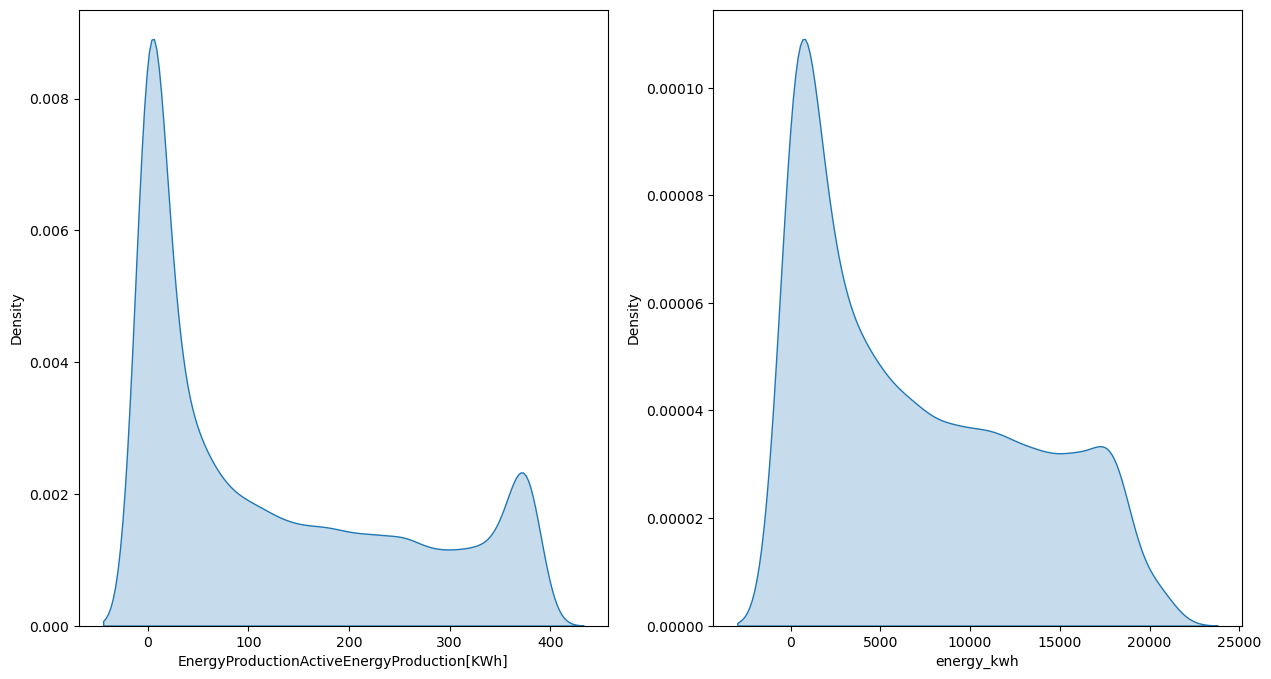

In [9]:
plt.figure(figsize=(15,8))
ax = plt.subplot(1, 2, 1)
sns.kdeplot(data=power,
            x='EnergyProductionActiveEnergyProduction[KWh]',
            fill=True,
            ax=ax)

ax2 = plt.subplot(1, 2, 2)
sns.kdeplot(data=gj_y,
            x='energy_kwh',
            fill=True, 
            ax=ax2)
plt.show()

In [10]:
from scipy.stats import pearsonr
tmp = pd.merge(gj_y, power[['dt', 'EnergyProductionActiveEnergyProduction[KWh]']],
               how='inner', on='dt')

pearsonr(tmp['EnergyProductionActiveEnergyProduction[KWh]'], tmp['energy_kwh'])

PearsonRResult(statistic=0.8278242889898189, pvalue=0.0)

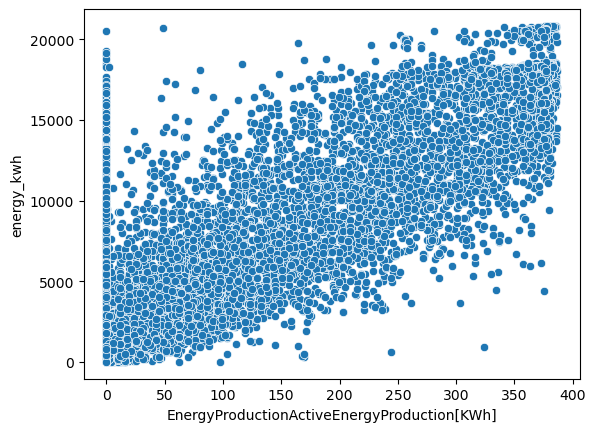

In [11]:
sns.scatterplot(data=tmp,
                x='EnergyProductionActiveEnergyProduction[KWh]',
                y='energy_kwh')
plt.show()

In [12]:
tmp.head()

plant_name                        dt  period_hours   energy_kwh  \
0       경주풍력 2020-01-01 01:00:00+09:00             1  9767.578125   
1       경주풍력 2020-01-01 02:00:00+09:00             1  5381.835938   
2       경주풍력 2020-01-01 03:00:00+09:00             1  3021.484375   
3       경주풍력 2020-01-01 04:00:00+09:00             1  4400.390625   
4       경주풍력 2020-01-01 05:00:00+09:00             1  4501.953125   

   EnergyProductionActiveEnergyProduction[KWh]  
0                                     0.000000  
1                                     0.000000  
2                                     0.000000  
3                                   137.695312  
4                                     0.000000

In [13]:
# 실제생산량에는 0이 많은 이유가?

# ActiveEnergyProduction에 0이 있는 이유
(가설)
* 점검 등의 기술적인 이유
* 단순히 풍속이 낮아서

In [11]:
power_0 = power.loc[power['EnergyProductionActiveEnergyProduction[KWh]'] == 0]
power_0.head()

dt WTG.Name WTG.Serial  \
2 2020-01-01 00:20:00+09:00    WTG01   U113-001   
3 2020-01-01 00:30:00+09:00    WTG01   U113-001   
4 2020-01-01 00:40:00+09:00    WTG01   U113-001   
5 2020-01-01 00:50:00+09:00    WTG01   U113-001   
6 2020-01-01 01:00:00+09:00    WTG01   U113-001   

   AvailabilityForcedOutageTime[Min.]  AvailabilityFullPerformanceTime[Min.]  \
2                                 0.0                               0.033333   
3                                 0.0                               0.033333   
4                                 0.0                               0.000000   
5                                 0.0                               0.000000   
6                                 0.0                               0.000000   

   AvailabilityRequestedShutdownTime[Min.]  \
2                                      0.0   
3                                      0.0   
4                                      0.0   
5                                      0.0   
6                                      0.0   

   AvailabilityScheduledMaintenanceTime[Min.]  \
2                                         0.0   
3                                         0.0   
4                                         0.0   
5                                         0.0   
6                                         0.0   

   AvailabilityTechnicalStandbyTime[Min.]  \
2                                8.866667   
3                                3.300000   
4                                0.000000   
5                                0.000000   
6                                0.000000   

   EnergyProductionActiveEnergyProduction[KWh]  \
2                                          0.0   
3                                          0.0   
4                                          0.0   
5                                          0.0   
6                                          0.0   

   GeneratorAverageWindingTemp.[℃]  ...  RotorBlade2Pos.[deg]  \
2                        83.386063  ...             90.080002   
3                        67.732239  ...             90.080002   
4                        63.201435  ...             90.080002   
5                        62.119621  ...             90.080002   
6                        61.640320  ...             90.080132   

   RotorBlade3Pos.[deg]  RotorMotor1Pos.[deg]  RotorMotor2Pos.[deg]  \
2             90.000130                  90.0                  90.0   
3             90.000031                  90.0                  90.0   
4             90.000031                  90.0                  90.0   
5             90.000000                  90.0                  90.0   
6             89.996765                  90.0                  90.0   

   RotorMotor3Pos.[deg]  RotorPitch1Angle[deg]  RotorPitch2Angle[deg]  \
2                  90.0                   90.0                   90.0   
3                  90.0                   90.0                   90.0   
4                  90.0                   90.0                   90.0   
5                  90.0                   90.0                   90.0   
6                  90.0                   90.0                   90.0   

   RotorPitch3Angle[deg]  RotorRotorSpeed[rpm]  YawYawcablewindup[deg]  
2                   90.0             -0.004660               402.67984  
3                   90.0              0.004165               402.67984  
4                   90.0              0.001102               402.67984  
5                   90.0             -0.002322               402.67984  
6                   90.0              0.007092               402.67984  

[5 rows x 29 columns]

In [12]:
columns = power.columns[power.columns.str.contains('Grid')]
tmp = power[columns]

display(tmp.describe())

columns = power_0.columns[power_0.columns.str.contains('Grid')]
tmp = power_0[columns]

display(tmp.describe())

GridActivePower[kW]  GridReactivePower[kVAr]
count         52589.000000             52589.000000
mean            755.031677                85.632507
std             783.523560                43.738457
min             -30.025930                 0.000000
25%              39.956017                82.197121
50%             451.648010                89.755180
75%            1378.048706               113.170723
max            2332.774414               169.270096

GridActivePower[kW]  GridReactivePower[kVAr]
count         10997.000000             10997.000000
mean              4.617043                12.882832
std             105.684616                13.447702
min             -30.025930                 0.000000
25%              -2.133754                 9.102040
50%              -1.320563                 9.576470
75%              -0.924447                10.311216
max            2230.229248               152.743546

In [13]:
columns = power.columns[(power.columns.str.contains('Availability'))
                        | (power.columns == 'EnergyProductionActiveEnergyProduction[KWh]')]
tmp = power[columns]

display(tmp.describe())
display(tmp.corr().style.background_gradient())

AvailabilityForcedOutageTime[Min.]  \
count                        52589.000000   
mean                             0.295213   
std                              1.661874   
min                              0.000000   
25%                              0.000000   
50%                              0.000000   
75%                              0.000000   
max                             10.000000   

       AvailabilityFullPerformanceTime[Min.]  \
count                           52589.000000   
mean                                7.783504   
std                                 4.070228   
min                                 0.000000   
25%                                10.000000   
50%                                10.000000   
75%                                10.000000   
max                                10.000000   

       AvailabilityRequestedShutdownTime[Min.]  \
count                             52589.000000   
mean                                  0.378652   
std                                   1.884905   
min                                   0.000000   
25%                                   0.000000   
50%                                   0.000000   
75%                                   0.000000   
max                                  10.000000   

       AvailabilityScheduledMaintenanceTime[Min.]  \
count                                52589.000000   
mean                                     0.013200   
std                                      0.361123   
min                                      0.000000   
25%                                      0.000000   
50%                                      0.000000   
75%                                      0.000000   
max                                     10.000000   

       AvailabilityTechnicalStandbyTime[Min.]  \
count                            52589.000000   
mean                                 0.188621   
std                                  1.055029   
min                                  0.000000   
25%                                  0.000000   
50%                                  0.000000   
75%                                  0.000000   
max                                 10.000000   

       EnergyProductionActiveEnergyProduction[KWh]  
count                                 52589.000000  
mean                                    125.294128  
std                                     129.992203  
min                                       0.000000  
25%                                       6.835938  
50%                                      74.218750  
75%                                     228.515625  
max                                     388.671875

In [14]:
# FullPerformanceTime이 그나마 연관이 있어보이는데, 오히려 점검, 보수 등 작동을 멈추는 것에 대한 얘기는 아닌듯 함.

In [21]:
from astral import LocationInfo
from astral.sun import sun
import pytz
import swifter


# day and night
location = LocationInfo("yeonggwang", "Korea", "Asia/Seoul", 35.25257837, 126.34227347)

def is_day_or_night(dt):
    s = sun(location.observer, date=dt)
    sunrise = s['sunrise']
    sunset = s['sunset']
#     dt = dt.tz_localize('Asia/Seoul')
    if sunrise < dt < sunset:
            return 0 # Day
    else:
            return 1 # Night.

ldaps['Night'] = ldaps['dt'].swifter.apply(lambda x : is_day_or_night(x))

Dask Apply:   0%|          | 0/24 [00:00<?, ?it/s]

C:\Users\jhk32\AppData\Local\Temp\ipykernel_7456\4223493672.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldaps['Night'] = ldaps['dt'].swifter.apply(lambda x : is_day_or_night(x))


# 변수별 상관계수 확인

In [9]:
tmp = pd.merge(gj_y, power,
               how='inner', on='dt').rename({'WTG.Name': 'turbine_id'}, axis=1)

tmp = pd.merge(tmp, ldaps,
               how='inner', on=['dt', 'turbine_id'])

# (tmp.corr(numeric_only=True)
#  .style
#  .background_gradient())
# plt.figure(figsize=(20,20))
# sns.heatmap(data=tmp.corr(numeric_only=True),
#             annot=True,
#             fmt='.2f',
#             cmap='Blues')

# plt.show()

# del tmp

In [10]:
tmp.head()

plant_name                        dt  period_hours    energy_kwh turbine_id  \
0       경주풍력 2020-01-02 00:00:00+09:00             1  17827.148438      WTG01   
1       경주풍력 2020-01-02 01:00:00+09:00             1  17616.210938      WTG01   
2       경주풍력 2020-01-02 02:00:00+09:00             1  17904.296875      WTG01   
3       경주풍력 2020-01-02 03:00:00+09:00             1  17676.757812      WTG01   
4       경주풍력 2020-01-02 04:00:00+09:00             1  18519.531250      WTG01   

  WTG.Serial  AvailabilityForcedOutageTime[Min.]  \
0   U113-001                                 0.0   
1   U113-001                                 0.0   
2   U113-001                                 0.0   
3   U113-001                                 0.0   
4   U113-001                                 0.0   

   AvailabilityFullPerformanceTime[Min.]  \
0                                   10.0   
1                                   10.0   
2                                   10.0   
3                                   10.0   
4                                   10.0   

   AvailabilityRequestedShutdownTime[Min.]  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   AvailabilityScheduledMaintenanceTime[Min.]  ...  frictional_vmax_50m  \
0                                         0.0  ...            10.428498   
1                                         0.0  ...            10.472921   
2                                         0.0  ...            10.682985   
3                                         0.0  ...            10.676681   
4                                         0.0  ...            10.079557   

   frictional_vmin_50m      pressure  relative_humid  specific_humid  \
0            10.059580  97974.593750       91.796478        0.002686   
1            10.044404  97970.132812       91.729774        0.002686   
2            10.478634  97951.546875       92.788666        0.002686   
3            10.090029  97908.968750       92.494576        0.002686   
4             9.672620  97858.398438       88.986443        0.002686   

     temp_air  storm_u_5m  storm_v_5m  wind_u_10m  wind_v_10m  
0  269.467560    0.021201   -0.375756    7.353266   -2.640615  
1  269.430847    0.020706   -0.371947    7.578446   -2.414076  
2  269.374390    0.020556   -0.354397    7.654554   -2.259913  
3  269.352112    0.021635   -0.328609    7.275844   -2.280371  
4  269.413269    0.024231   -0.265124    6.911751   -1.920128  

[5 rows x 45 columns]

In [11]:
tmp['wind_speed'] = uv_to_wsd(tmp['wind_u_10m'], tmp['wind_v_10m'])
tmp['wind_speed_100m'] = logarithmic_profile(tmp['wind_speed'])

(array([7.8130255, 7.953654 , 7.981191 , ..., 5.429144 , 4.248816 ,
        4.5049686], dtype=float32),
 array([289.7536 , 287.669  , 286.44858, ..., 267.86176, 268.76688,
        269.3796 ], dtype=float32))

In [43]:
power.head()

dt WTG.Name WTG.Serial  \
0 2020-01-01 00:00:00+09:00    WTG01   U113-001   
1 2020-01-01 00:10:00+09:00    WTG01   U113-001   
2 2020-01-01 00:20:00+09:00    WTG01   U113-001   
3 2020-01-01 00:30:00+09:00    WTG01   U113-001   
4 2020-01-01 00:40:00+09:00    WTG01   U113-001   

   AvailabilityForcedOutageTime[Min.]  AvailabilityFullPerformanceTime[Min.]  \
0                                 0.0                              10.000000   
1                                 0.0                               7.233333   
2                                 0.0                               0.033333   
3                                 0.0                               0.033333   
4                                 0.0                               0.000000   

   AvailabilityRequestedShutdownTime[Min.]  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   AvailabilityScheduledMaintenanceTime[Min.]  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   

   AvailabilityTechnicalStandbyTime[Min.]  \
0                                0.000000   
1                                0.000000   
2                                8.866667   
3                                3.300000   
4                                0.000000   

   EnergyProductionActiveEnergyProduction[KWh]  \
0                                   379.882812   
1                                   300.781250   
2                                     0.000000   
3                                     0.000000   
4                                     0.000000   

   GeneratorAverageWindingTemp.[℃]  ...  RotorBlade2Pos.[deg]  \
0                        92.984619  ...             13.507234   
1                        98.441666  ...             23.934601   
2                        83.386063  ...             90.080002   
3                        67.732239  ...             90.080002   
4                        63.201435  ...             90.080002   

   RotorBlade3Pos.[deg]  RotorMotor1Pos.[deg]  RotorMotor2Pos.[deg]  \
0             13.473200             13.369333             13.370267   
1             23.891001             23.818966             23.819099   
2             90.000130             90.000000             90.000000   
3             90.000031             90.000000             90.000000   
4             90.000031             90.000000             90.000000   

   RotorMotor3Pos.[deg]  RotorPitch1Angle[deg]  RotorPitch2Angle[deg]  \
0             13.369933              13.369333              13.371600   
1             23.819300              23.818966              23.819099   
2             90.000000              90.000000              90.000000   
3             90.000000              90.000000              90.000000   
4             90.000000              90.000000              90.000000   

   RotorPitch3Angle[deg]  RotorRotorSpeed[rpm]  YawYawcablewindup[deg]  
0              13.369933             13.455300               402.67984  
1              23.819300             11.564468               402.67984  
2              90.000000             -0.004660               402.67984  
3              90.000000              0.004165               402.67984  
4              90.000000              0.001102               402.67984  

[5 rows x 29 columns]

In [49]:
for i in range(1, 4):
    same1 = sum(power[f'RotorBlade{i}Pos.[deg]'] == power[f'RotorPitch{i}Angle[deg]']) / power.shape[0] * 100
    same2 = sum(power[f'RotorBlade{i}Pos.[deg]'] == power[f'RotorMotor{i}Pos.[deg]']) / power.shape[0] * 100
    same3 = sum(power[f'RotorPitch{i}Angle[deg]'] == power[f'RotorMotor{i}Pos.[deg]']) / power.shape[0] * 100
    print(f"Blade{i} Pos/Pitch Similarity: ", same1)
    print(f"Blade{i} Pos/Motor Similarity: ", same2)
    print(f"Blade{i} Pitch/Motor Similarity: ", same3)
    print("-" * 50)

Blade1 Pos/Pitch Similarity:  3.2687444142311133
Blade1 Pos/Motor Similarity:  3.2725474909201546
Blade1 Pitch/Motor Similarity:  95.2632679837989
--------------------------------------------------
Blade2 Pos/Pitch Similarity:  1.6353229762878168
Blade2 Pos/Motor Similarity:  1.633421437943296
Blade2 Pitch/Motor Similarity:  91.11981593108825
--------------------------------------------------
Blade3 Pos/Pitch Similarity:  3.4741105554393505
Blade3 Pos/Motor Similarity:  3.4722090170948294
Blade3 Pitch/Motor Similarity:  97.60596322424841
--------------------------------------------------


In [23]:
# elevation, landcover, surf_rough는 상관성 없음
# Rotor blade1 등의 feature들은 서로 상관관계가 매우 높음
# grid_active, reactive power,energy production, winding temp끼리는 서로 상관관계가 매우 높음.
# rotor motor speed, nacelle wind speed, 바로 위에 상기한 feature들은 target값과 상관관계가 높음.
# 

# 변수를 추가해보자

In [39]:
ldaps.loc[:,'tke_5m'] = 0.5 * (ldaps['storm_u_5m'] ** 2 + ldaps['storm_v_5m'] ** 2)

ldaps.loc[:, 'storm/wind_u'] = ldaps['storm_u_5m'] / ldaps['wind_u_10m']
ldaps.loc[:, 'storm/wind_v'] = ldaps['storm_v_5m'] / ldaps['wind_v_10m']

ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(
    ldaps["wind_u_10m"], ldaps["wind_v_10m"]
)

C:\Users\jhk32\AppData\Local\Temp\ipykernel_7456\1504128810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(
C:\Users\jhk32\AppData\Local\Temp\ipykernel_7456\1504128810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(


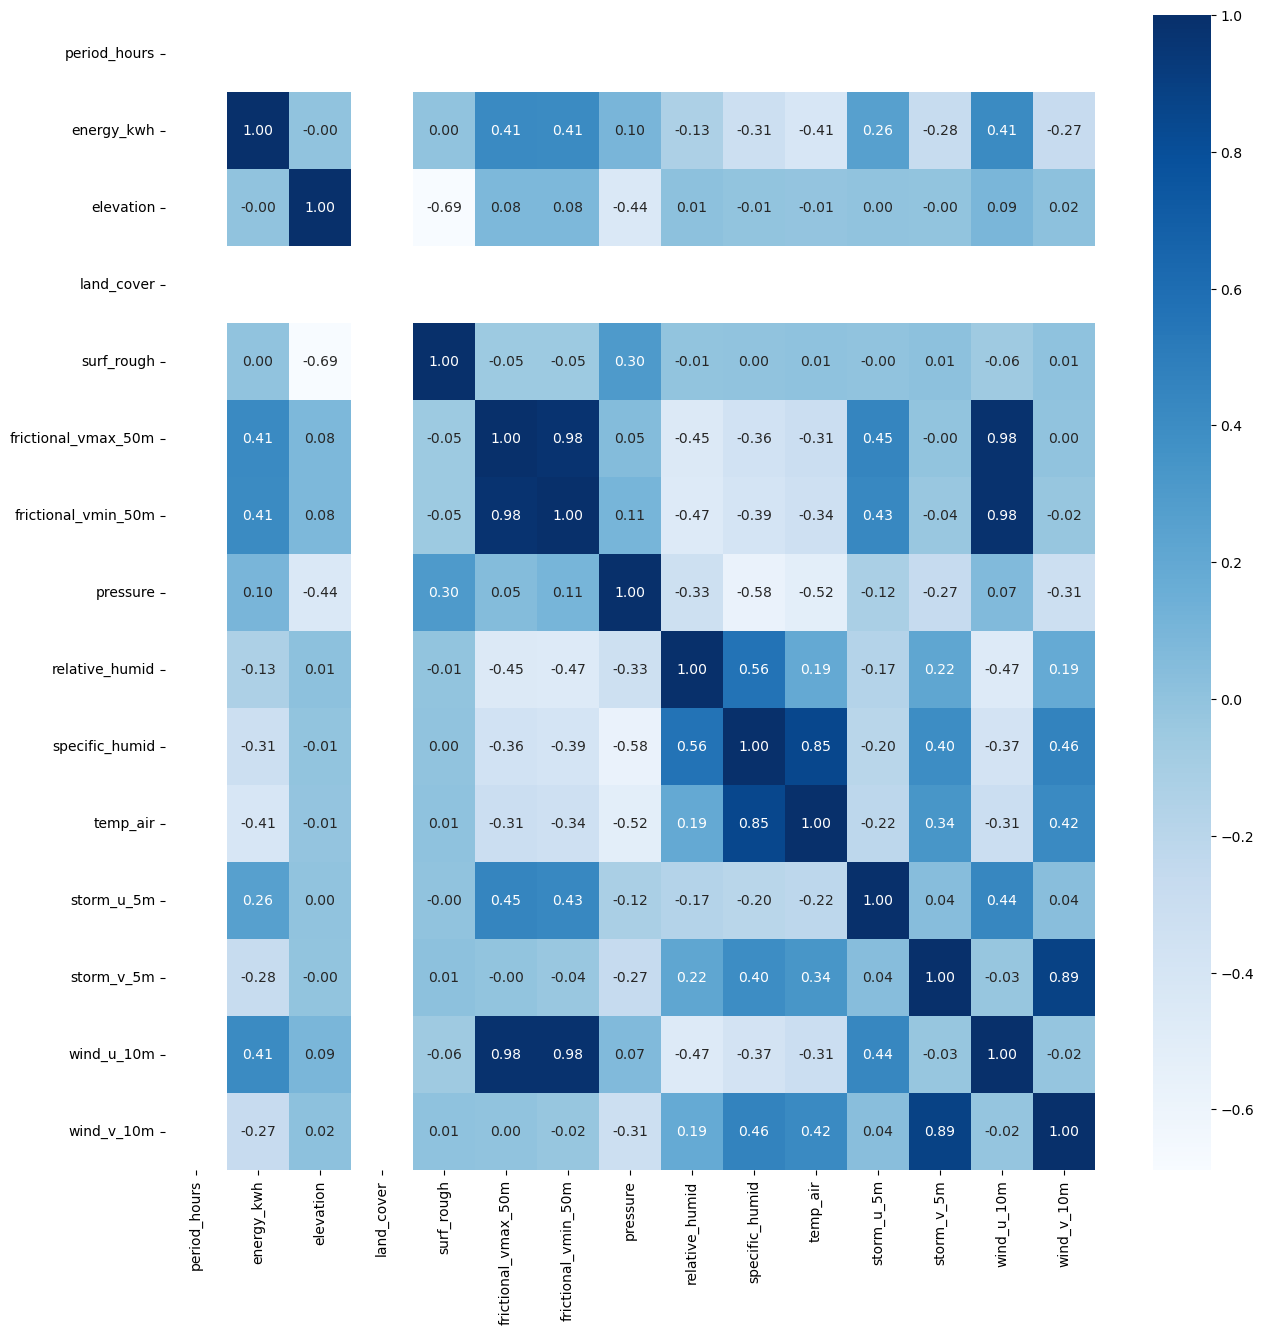

In [14]:
tmp = pd.merge(gj_y, ldaps,
               how='inner', on='dt')

plt.figure(figsize=(15,15))
sns.heatmap(data=tmp.corr(numeric_only=True, method='pearson'),
            annot=True,
            fmt='.2f',
            cmap='Blues')

plt.show()
del tmp

### Mutual Information

In [15]:
from sklearn.feature_selection import mutual_info_regression

['plant_name',
 'dt',
 'period_hours',
 'energy_kwh',
 'elevation',
 'land_cover',
 'surf_rough',
 'frictional_vmax_50m',
 'frictional_vmin_50m',
 'pressure',
 'relative_humid',
 'specific_humid',
 'temp_air',
 'storm_u_5m',
 'storm_v_5m',
 'wind_u_10m',
 'wind_v_10m',
 'turbine_id']

<Axes: >

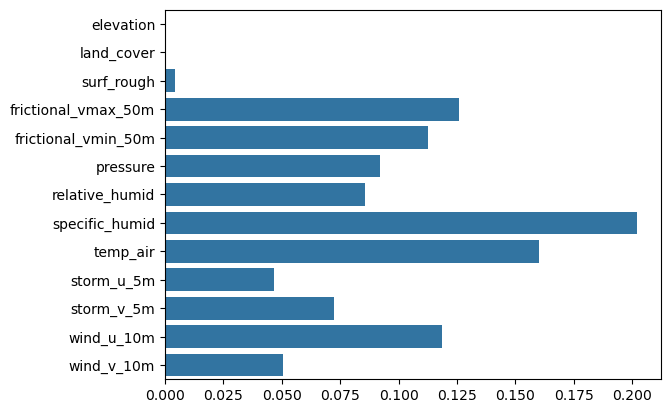

In [29]:
tmp = pd.merge(gj_y, ldaps[ldaps['turbine_id']=='WTG01'],
               how='inner', on='dt')

tmp.drop(['plant_name', 'dt', 'period_hours', 'turbine_id'], 
         axis=1, 
         inplace=True)

tmp['energy_kwh'] = tmp['energy_kwh'].shift(24)
x = tmp.dropna(axis=0).drop('energy_kwh', axis=1)
y = tmp.dropna(axis=0)['energy_kwh']

ml = mutual_info_regression(X=x[list(x)], y=y)

sns.barplot(x=ml, y=list(x),
            orient='h')

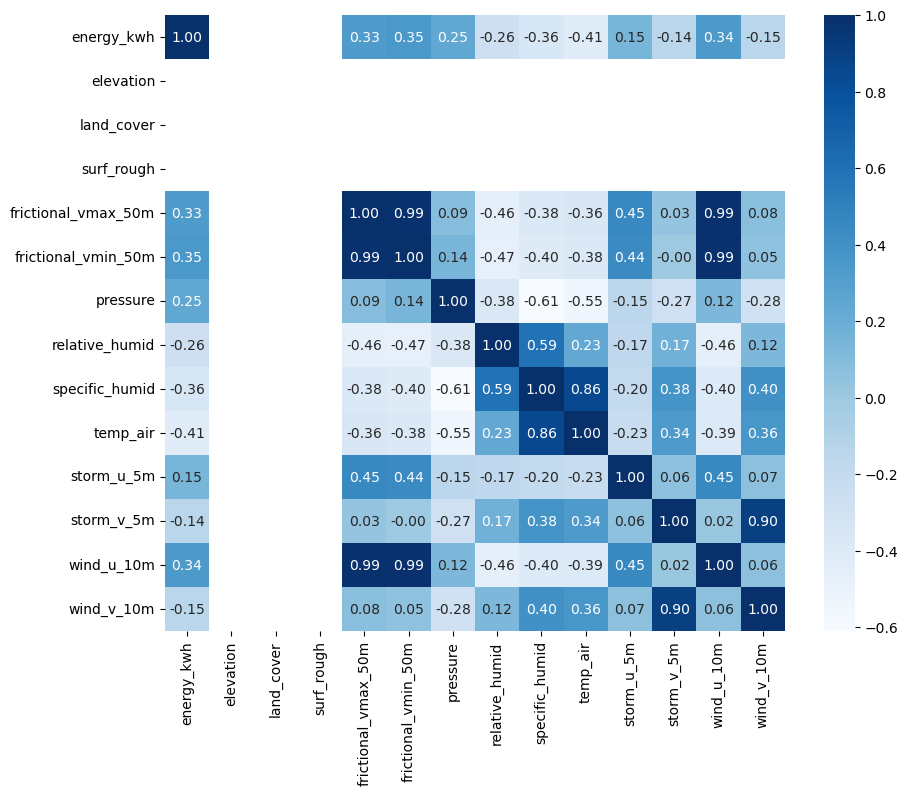

In [32]:
corr_tmp = tmp.dropna(axis=0).corr()
plt.figure(figsize=(10,8))
sns.heatmap(data=corr_tmp,
            cmap='Blues',
            annot=True,
            fmt='.2f')
plt.show()

# scada와 ldaps 차이

### 1. wind speed

In [70]:
# 터빈 개수가 적은 경주풍력에 대해서만 한번 진행
power = pd.read_parquet(INPUT_PATH + "dynamic_report_ewp02_2020_10min.parquet").rename({'Date/Time': 'dt'}, axis=1)
power2 = pd.read_parquet(INPUT_PATH + "dynamic_report_ewp02_2021_10min.parquet").rename({'Date/Time': 'dt'}, axis=1)
gj_y = pd.read_parquet(INPUT_PATH + "train_y.parquet").rename({'end_datetime': 'dt'}, axis=1)
ldaps = pd.read_parquet(INPUT_PATH + "train_ldaps_gyeongju.parquet")

print("Power: ", power.shape)
print("train_y: ", gj_y.shape)
print("LDAPS: ", ldaps.shape)

Power:  (52592, 29)
train_y:  (52608, 4)
LDAPS:  (235818, 15)


In [71]:
# data slicing
power, power2 = power[:-3], power2[:-3]

datas = [power, power2, gj_y, ldaps]
for d in datas:
    try:
        d['dt'] = (pd.to_datetime(d['dt'])
                    .dt
                    .tz_convert("Asia/Seoul"))
    except TypeError:
        d['dt'] = (pd.to_datetime(d['dt'])
                    .dt
                    .tz_localize("Asia/Seoul"))

gj_y = (gj_y.loc[(gj_y['plant_name'] == "경주풍력")
                 & (gj_y['dt']).between('2020-01-01', '2021-01-01', inclusive='left')])

ldaps = ldaps.loc[ldaps['dt'].between('2020-01-01', '2021-01-01', inclusive='left')]

print("Power: ", power.shape, power['dt'].min(), power['dt'].max())
print("train_y: ", gj_y.shape, gj_y['dt'].min(), gj_y['dt'].max())
print("LDAPS: ", ldaps.shape, ldaps['dt'].min(), ldaps['dt'].max())

Power:  (52589, 29) 2020-01-01 00:00:00+09:00 2020-12-31 23:50:00+09:00
train_y:  (8783, 4) 2020-01-01 01:00:00+09:00 2020-12-31 23:00:00+09:00
LDAPS:  (78840, 15) 2020-01-02 00:00:00+09:00 2020-12-31 23:00:00+09:00


In [72]:
ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(
    ldaps["wind_u_10m"], ldaps["wind_v_10m"]
)

power.rename({'WTG.Name': 'turbine_id'}, axis=1, inplace=True)
tmp = pd.merge(gj_y, power,
               how='inner', on=['dt'])

tmp = pd.merge(tmp, ldaps,
               how='inner', on=['dt', 'turbine_id'])

tmp.head()

C:\Users\jhk32\AppData\Local\Temp\ipykernel_16720\209884163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(
C:\Users\jhk32\AppData\Local\Temp\ipykernel_16720\209884163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(


plant_name                        dt  period_hours    energy_kwh turbine_id  \
0       경주풍력 2020-01-02 00:00:00+09:00             1  17827.148438      WTG01   
1       경주풍력 2020-01-02 01:00:00+09:00             1  17616.210938      WTG01   
2       경주풍력 2020-01-02 02:00:00+09:00             1  17904.296875      WTG01   
3       경주풍력 2020-01-02 03:00:00+09:00             1  17676.757812      WTG01   
4       경주풍력 2020-01-02 04:00:00+09:00             1  18519.531250      WTG01   

  WTG.Serial  AvailabilityForcedOutageTime[Min.]  \
0   U113-001                                 0.0   
1   U113-001                                 0.0   
2   U113-001                                 0.0   
3   U113-001                                 0.0   
4   U113-001                                 0.0   

   AvailabilityFullPerformanceTime[Min.]  \
0                                   10.0   
1                                   10.0   
2                                   10.0   
3                                   10.0   
4                                   10.0   

   AvailabilityRequestedShutdownTime[Min.]  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   AvailabilityScheduledMaintenanceTime[Min.]  ...      pressure  \
0                                         0.0  ...  97974.593750   
1                                         0.0  ...  97970.132812   
2                                         0.0  ...  97951.546875   
3                                         0.0  ...  97908.968750   
4                                         0.0  ...  97858.398438   

   relative_humid  specific_humid    temp_air  storm_u_5m  storm_v_5m  \
0       91.796478        0.002686  269.467560    0.021201   -0.375756   
1       91.729774        0.002686  269.430847    0.020706   -0.371947   
2       92.788666        0.002686  269.374390    0.020556   -0.354397   
3       92.494576        0.002686  269.352112    0.021635   -0.328609   
4       88.986443        0.002686  269.413269    0.024231   -0.265124   

   wind_u_10m  wind_v_10m  wind_speed  wind_direction  
0    7.353266   -2.640615    7.813025      289.753601  
1    7.578446   -2.414076    7.953654      287.669006  
2    7.654554   -2.259913    7.981191      286.448578  
3    7.275844   -2.280371    7.624827      287.401855  
4    6.911751   -1.920128    7.173506      285.525635  

[5 rows x 47 columns]

                       wind_speed  NacelleWindSpeed[m/s]
wind_speed               1.000000               0.710568
NacelleWindSpeed[m/s]    0.710568               1.000000


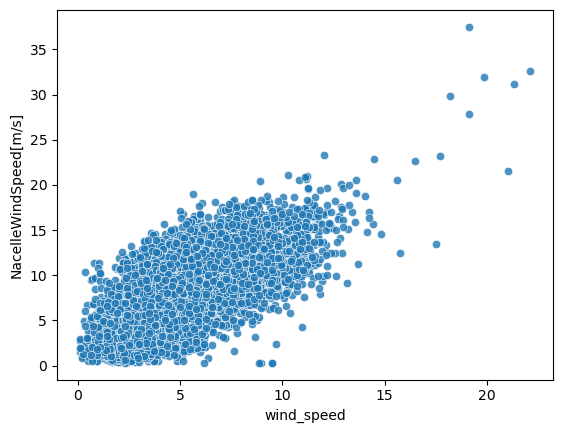

In [74]:
print(tmp[['wind_speed', 'NacelleWindSpeed[m/s]']].corr())

sns.scatterplot(data=tmp,
                x='wind_speed', y='NacelleWindSpeed[m/s]',
                alpha=0.8, sizes=30)
plt.show()

In [25]:
from windpowerlib.wind_speed import logarithmic_profile

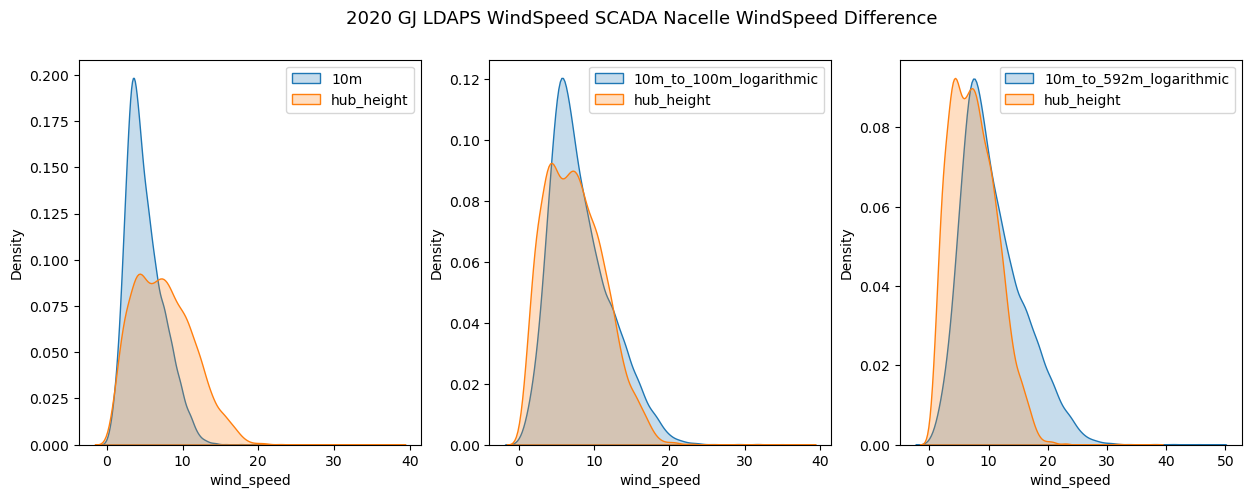

In [148]:
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
sns.kdeplot(data=tmp,
            x='wind_speed', label='10m',
            fill=True, ax=ax1)
sns.kdeplot(data=tmp,
            x='NacelleWindSpeed[m/s]', label='hub_height',
            fill=True, ax=ax1)
ax1.legend()

log_speed = logarithmic_profile(tmp['wind_speed'], 10, 100, 0.286911)

ax2 = plt.subplot(1, 3, 2)
sns.kdeplot(x=log_speed, label='10m_to_100m_logarithmic',
            fill=True, ax=ax2)
sns.kdeplot(data=tmp,
            x='NacelleWindSpeed[m/s]', label='hub_height',
            fill=True, ax=ax2)
ax2.legend()

log_speed = logarithmic_profile(tmp['wind_speed'], 10, 492 + 100, 0.286911)

ax3 = plt.subplot(1, 3, 3)
sns.kdeplot(x=log_speed, label='10m_to_592m_logarithmic',
            fill=True, ax=ax3)
sns.kdeplot(data=tmp,
            x='NacelleWindSpeed[m/s]', label='hub_height',
            fill=True, ax=ax3)
ax3.legend()

plt.suptitle("2020 GJ LDAPS WindSpeed SCADA Nacelle WindSpeed Difference", fontsize=13)
plt.show()

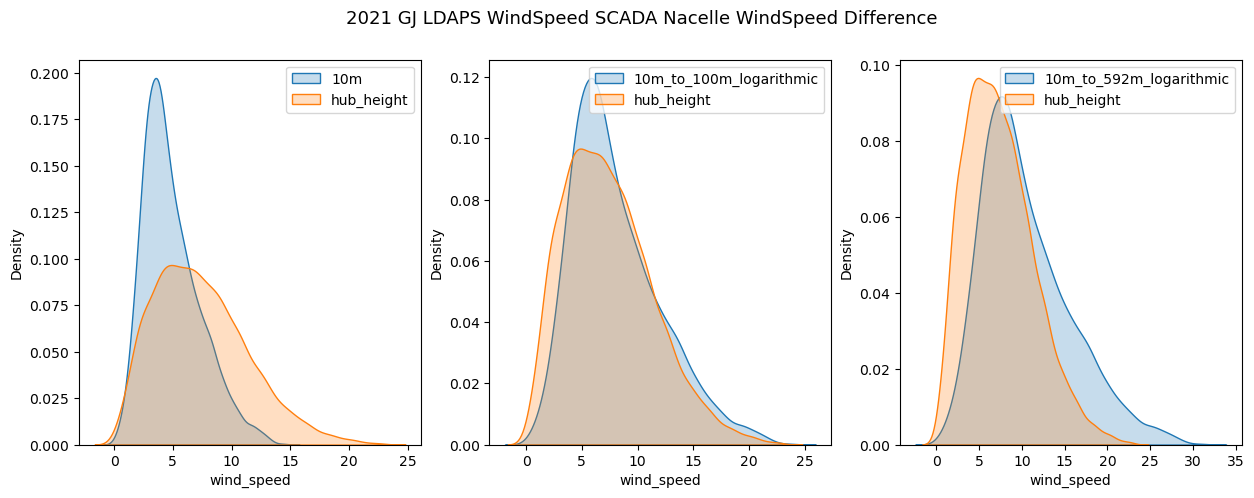

In [68]:
power2.rename({'WTG.Name': 'turbine_id'}, axis=1, inplace=True)
tmp = pd.merge(gj_y, power2,
               how='inner', on=['dt'])

tmp = pd.merge(tmp, ldaps,
               how='inner', on=['dt', 'turbine_id'])

tmp.head()

plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
sns.kdeplot(data=tmp,
            x='wind_speed', label='10m',
            fill=True, ax=ax1)
sns.kdeplot(data=tmp,
            x='NacelleWindSpeed[m/s]', label='hub_height',
            fill=True, ax=ax1)
ax1.legend()

log_speed = logarithmic_profile(tmp['wind_speed'], 10, 100, 0.286911)

ax2 = plt.subplot(1, 3, 2)
sns.kdeplot(x=log_speed, label='10m_to_100m_logarithmic',
            fill=True, ax=ax2)
sns.kdeplot(data=tmp,
            x='NacelleWindSpeed[m/s]', label='hub_height',
            fill=True, ax=ax2)
ax2.legend()

log_speed = logarithmic_profile(tmp['wind_speed'], 10, 492 + 100, 0.286911)

ax3 = plt.subplot(1, 3, 3)
sns.kdeplot(x=log_speed, label='10m_to_592m_logarithmic',
            fill=True, ax=ax3)
sns.kdeplot(data=tmp,
            x='NacelleWindSpeed[m/s]', label='hub_height',
            fill=True, ax=ax3)
ax3.legend()

plt.suptitle("2021 GJ LDAPS WindSpeed SCADA Nacelle WindSpeed Difference", fontsize=13)
plt.show()

# wake loss 확인

In [94]:
ldaps[ldaps['wind_v_10m'] > 0].groupby('turbine_id')['wind_speed'].agg({'mean', 'median'})

median      mean
turbine_id                    
WTG01       3.766476  4.278940
WTG02       3.231766  3.654032
WTG03       3.396858  3.775943
WTG04       3.396858  3.775943
WTG05       3.396858  3.775943
WTG06       3.396858  3.775943
WTG07       3.396858  3.775943
WTG08       3.496629  3.870936
WTG09       3.496629  3.870936

In [95]:
ldaps[ldaps['wind_v_10m'] < 0].groupby('turbine_id')['wind_speed'].agg({'mean', 'median'})

median      mean
turbine_id                    
WTG01       4.990437  5.384251
WTG02       3.952269  4.309681
WTG03       3.865352  4.282964
WTG04       3.865352  4.282964
WTG05       3.865352  4.282964
WTG06       3.865352  4.282964
WTG07       3.865352  4.282964
WTG08       3.813313  4.274313
WTG09       3.813313  4.274313

In [143]:
x = ldaps.loc[(ldaps['turbine_id'] == 'WTG04') & (ldaps['dt'].dt.month.isin([12, 1, 2])), 'wind_speed'].values
y = ldaps.loc[(ldaps['turbine_id'] == 'WTG05') & (ldaps['dt'].dt.month.isin([12, 1, 2])), 'wind_speed'].values

sum(x - y)

0.0

<Axes: xlabel='wind_speed', ylabel='Density'>

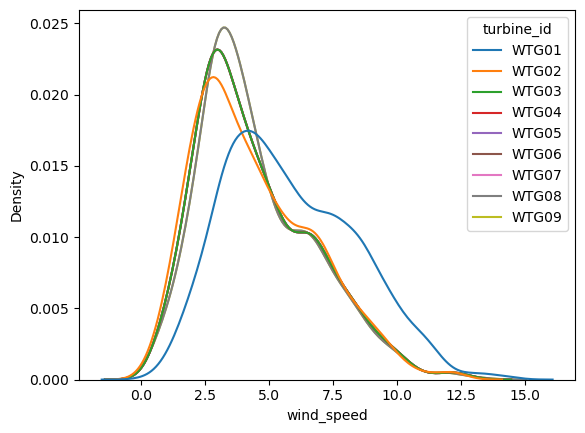

In [103]:
sns.kdeplot(data=ldaps[ldaps['dt'].dt.month.isin([12, 1, 2])],
            x='wind_speed', hue='turbine_id')

# 차이가 극명한 겨울로 확인

In [133]:
# from windpowerlib.wake_losses import reduce_wind_speed

# WTG01_wake_losses = reduce_wind_speed(ldaps.loc[(ldaps['turbine_id'] == 'WTG01') & (ldaps['dt'].dt.month.isin([12, 1, 2])), 'wind_speed'])
# WTG02_wake_losses = reduce_wind_speed(ldaps.loc[(ldaps['turbine_id'] == 'WTG02') & (ldaps['dt'].dt.month.isin([12, 1, 2])), 'wind_speed'])

# plt.figure(figsize=(15,7)) 
# ax1 = plt.subplot(1, 2, 1)
# sns.kdeplot(x=WTG01_wake_losses,
#             label='WTG01_WAKE',
#             fill=True,
#             ax=ax1)
# sns.kdeplot(x=ldaps.loc[(ldaps['turbine_id'] == 'WTG01') & (ldaps['dt'].dt.month.isin([12, 1, 2])), 'wind_speed'],
#             label='WTG01',
#             ax=ax1)
# sns.kdeplot(x=ldaps.loc[(ldaps['turbine_id'] == 'WTG02') & (ldaps['dt'].dt.month.isin([12, 1, 2])), 'wind_speed'],
#             label='WTG02',
#             fill=True,
#             ax=ax1)
# ax1.legend()

# ax2 = plt.subplot(1, 2, 2)
# sns.kdeplot(x=WTG02_wake_losses,
#             label='WTG02_WAKE',
#             fill=True,
#             ax=ax2)
# sns.kdeplot(x=ldaps.loc[(ldaps['turbine_id'] == 'WTG02') & (ldaps['dt'].dt.month.isin([12, 1, 2])), 'wind_speed'],
#             label='WTG02',
#             ax=ax2)
# sns.kdeplot(x=ldaps.loc[(ldaps['turbine_id'] == 'WTG03') & (ldaps['dt'].dt.month.isin([12, 1, 2])), 'wind_speed'],
#             label='WTG03',
#             fill=True,
#             ax=ax2)

# ax2.legend()
# plt.show()

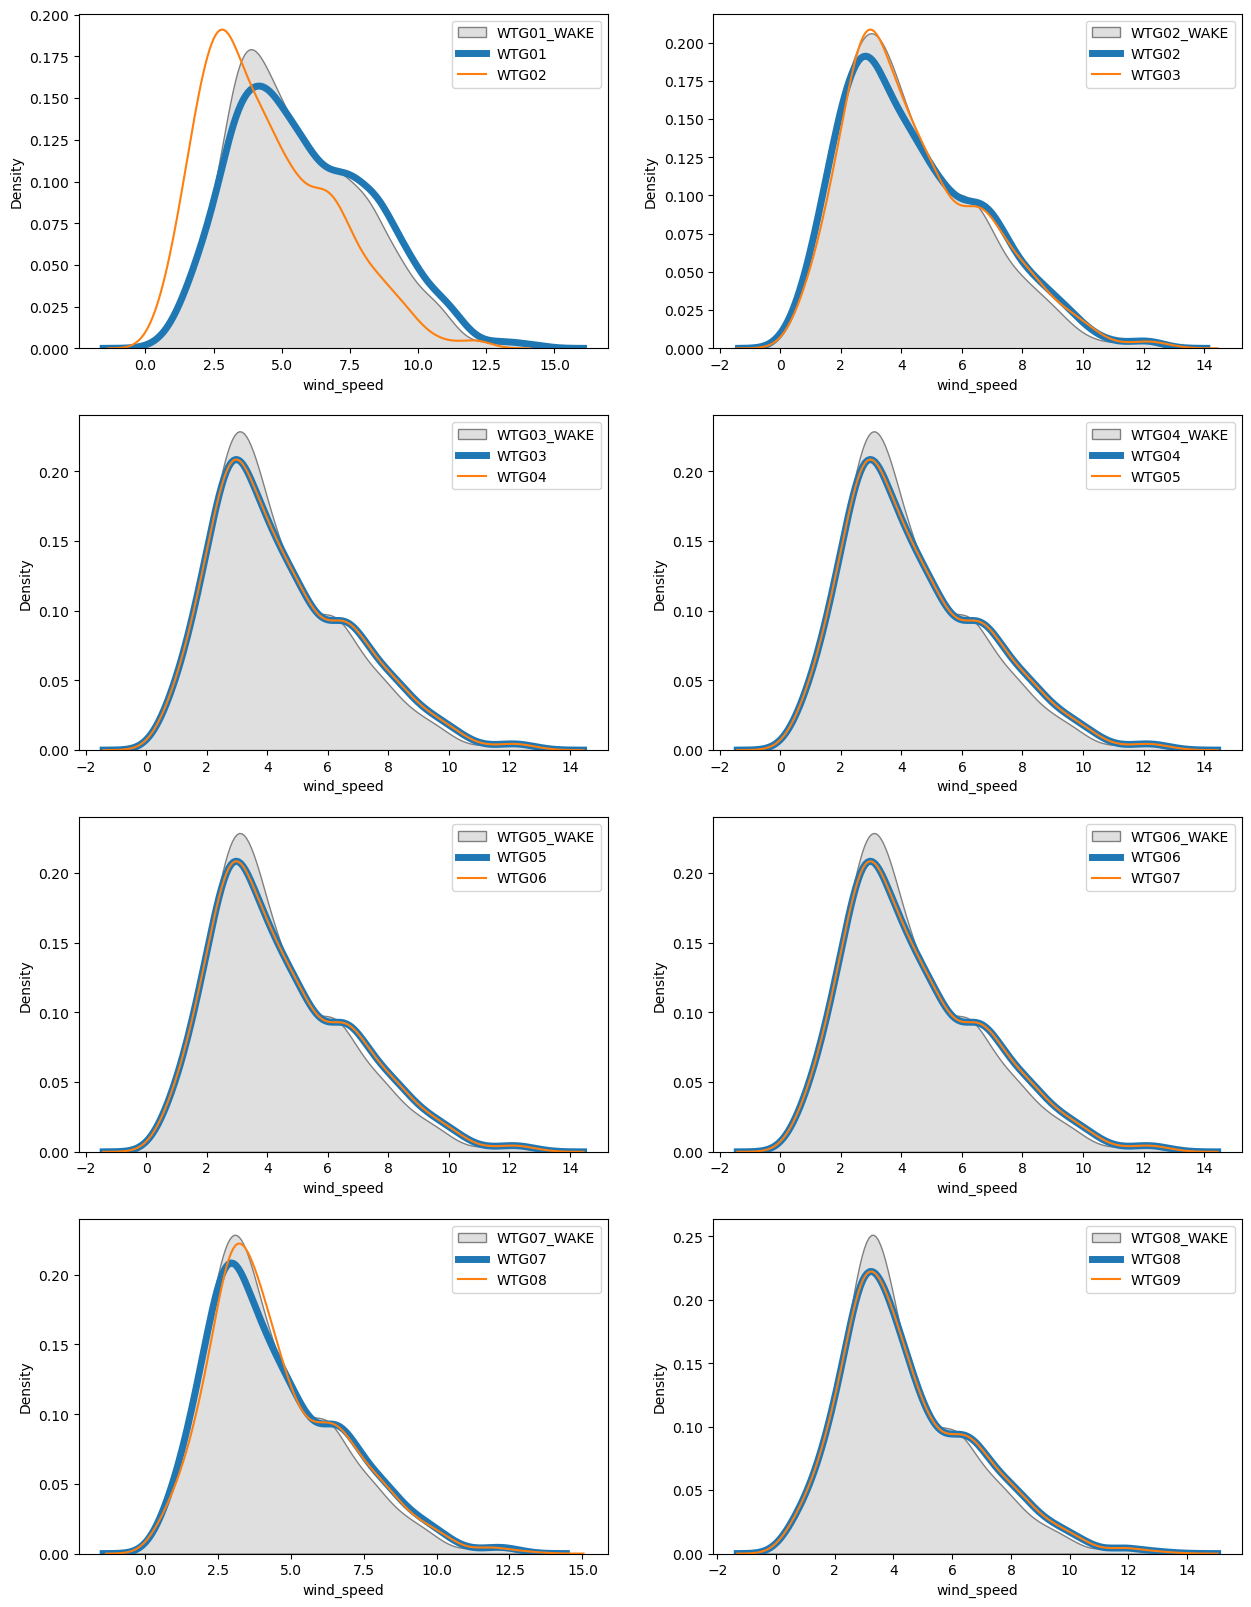

In [132]:
from windpowerlib.wake_losses import reduce_wind_speed

plt.figure(figsize=(15,20)) 

for i in range(1, 9):
    WTG_wake_losses = reduce_wind_speed(ldaps.loc[(ldaps['turbine_id'] == f'WTG0{i}') & (ldaps['dt'].dt.month.isin([12, 1, 2])), 'wind_speed'])
    ax = plt.subplot(4, 2, i)
    sns.kdeplot(x=WTG_wake_losses,
            label=f'WTG0{i}_WAKE',
            fill=True,
            color='gray',
            ax=ax)
    sns.kdeplot(x=ldaps.loc[(ldaps['turbine_id'] == f'WTG0{i}') & (ldaps['dt'].dt.month.isin([12, 1, 2])), 'wind_speed'],
                label=f'WTG0{i}',
                linewidth=5,
                ax=ax)
    sns.kdeplot(x=ldaps.loc[(ldaps['turbine_id'] == f'WTG0{i+1}') & (ldaps['dt'].dt.month.isin([12, 1, 2])), 'wind_speed'],
                label=f'WTG0{i+1}',
                fill=False,
                ax=ax)
    ax.legend()

plt.show()

# 기온 보정

In [164]:
from windpowerlib.temperature import linear_gradient

power = pd.read_parquet(INPUT_PATH + "dynamic_report_ewp02_2021_10min.parquet").rename({'Date/Time': 'dt'}, axis=1)
gj_y = pd.read_parquet(INPUT_PATH + "train_y.parquet").rename({'end_datetime': 'dt'}, axis=1)
ldaps = pd.read_parquet(INPUT_PATH + "train_ldaps_gyeongju.parquet")

print("Power: ", power.shape)
print("train_y: ", gj_y.shape)
print("LDAPS: ", ldaps.shape)

Power:  (52433, 29)
train_y:  (52608, 4)
LDAPS:  (235818, 15)


In [165]:
# data slicing
power = power[:-3]

datas = [power, gj_y, ldaps]
for d in datas:
    try:
        d['dt'] = (pd.to_datetime(d['dt'])
                    .dt
                    .tz_convert("Asia/Seoul"))
    except TypeError:
        d['dt'] = (pd.to_datetime(d['dt'])
                    .dt
                    .tz_localize("Asia/Seoul"))

gj_y = (gj_y.loc[(gj_y['plant_name'] == "경주풍력")
                 & (gj_y['dt']).between('2021-01-01', '2022-01-01', inclusive='left')])

ldaps = ldaps.loc[ldaps['dt'].between('2021-01-01', '2022-01-01', inclusive='left')]

print("Power: ", power.shape, power['dt'].min(), power['dt'].max())
print("train_y: ", gj_y.shape, gj_y['dt'].min(), gj_y['dt'].max())
print("LDAPS: ", ldaps.shape, ldaps['dt'].min(), ldaps['dt'].max())

Power:  (52430, 29) 2021-01-01 00:00:00+09:00 2021-12-31 23:50:00+09:00
train_y:  (8760, 4) 2021-01-01 00:00:00+09:00 2021-12-31 23:00:00+09:00
LDAPS:  (78831, 15) 2021-01-01 00:00:00+09:00 2021-12-31 23:00:00+09:00


In [166]:
ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(
    ldaps["wind_u_10m"], ldaps["wind_v_10m"]
)

power.rename({'WTG.Name': 'turbine_id'}, axis=1, inplace=True)
tmp = pd.merge(gj_y, power,
               how='inner', on=['dt'])

tmp = pd.merge(tmp, ldaps,
               how='inner', on=['dt', 'turbine_id'])

tmp.head()

C:\Users\jhk32\AppData\Local\Temp\ipykernel_16720\209884163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(
C:\Users\jhk32\AppData\Local\Temp\ipykernel_16720\209884163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(


plant_name                        dt  period_hours    energy_kwh turbine_id  \
0       경주풍력 2021-01-01 00:00:00+09:00             1  17273.437500      WTG01   
1       경주풍력 2021-01-01 01:00:00+09:00             1  18119.140625      WTG01   
2       경주풍력 2021-01-01 02:00:00+09:00             1  17664.062500      WTG01   
3       경주풍력 2021-01-01 03:00:00+09:00             1  17691.406250      WTG01   
4       경주풍력 2021-01-01 04:00:00+09:00             1  15314.453125      WTG01   

  WTG.Serial  AvailabilityForcedOutageTime[Min.]  \
0   U113-001                                 0.0   
1   U113-001                                 0.0   
2   U113-001                                 0.0   
3   U113-001                                 0.0   
4   U113-001                                 0.0   

   AvailabilityFullPerformanceTime[Min.]  \
0                                   10.0   
1                                   10.0   
2                                   10.0   
3                                   10.0   
4                                   10.0   

   AvailabilityRequestedShutdownTime[Min.]  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   AvailabilityScheduledMaintenanceTime[Min.]  ...      pressure  \
0                                         0.0  ...  97421.031250   
1                                         0.0  ...  97426.148438   
2                                         0.0  ...  97458.406250   
3                                         0.0  ...  97480.046875   
4                                         0.0  ...  97487.289062   

   relative_humid  specific_humid    temp_air  storm_u_5m  storm_v_5m  \
0       98.096130        0.001953  264.102173    0.122864   -0.093026   
1      101.684967        0.001953  263.825745    0.131611   -0.091649   
2      103.387093        0.001953  263.540405    0.141142   -0.074264   
3       93.023613        0.001709  263.773071    0.150186   -0.128167   
4       91.892479        0.001709  263.556335    0.143697   -0.218682   

   wind_u_10m  wind_v_10m  wind_speed  wind_direction  
0    3.172033   -1.847563    3.670869      300.218811  
1    3.589401   -1.373417    3.843186      290.938416  
2    3.666726   -1.218857    3.864000      288.387329  
3    5.362698   -1.853392    5.673939      289.065552  
4    5.573533   -1.976845    5.913729      289.528809  

[5 rows x 47 columns]

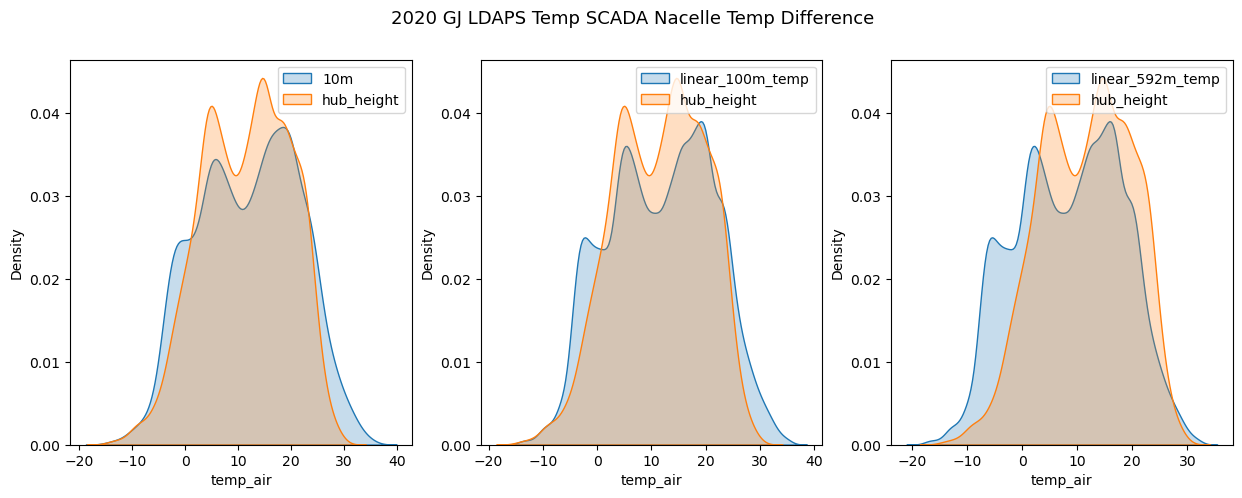

In [156]:
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 3, 1)
sns.kdeplot(x=tmp['temp_air'] - 273.15, label='10m',
            fill=True, ax=ax1)
sns.kdeplot(data=tmp,
            x='NacelleOutdoorTemp[℃]', label='hub_height',
            fill=True, ax=ax1)
ax1.legend()

hub_temperature = linear_gradient(ldaps['temp_air'], 0, 100)

ax2 = plt.subplot(1, 3, 2)
sns.kdeplot(x=hub_temperature - 273.15, label='linear_100m_temp',
            fill=True, ax=ax2)
sns.kdeplot(data=tmp,
            x='NacelleOutdoorTemp[℃]', label='hub_height',
            fill=True, ax=ax2)
ax2.legend()

hub_temperature = linear_gradient(ldaps['temp_air'], 0, 492 + 100)

ax3 = plt.subplot(1, 3, 3)
sns.kdeplot(x=hub_temperature - 273.15, label='linear_592m_temp',
            fill=True, ax=ax3)
sns.kdeplot(data=tmp,
            x='NacelleOutdoorTemp[℃]', label='hub_height',
            fill=True, ax=ax3)
ax3.legend()

plt.suptitle("2020 GJ LDAPS Temp SCADA Nacelle Temp Difference", fontsize=13)
plt.show()

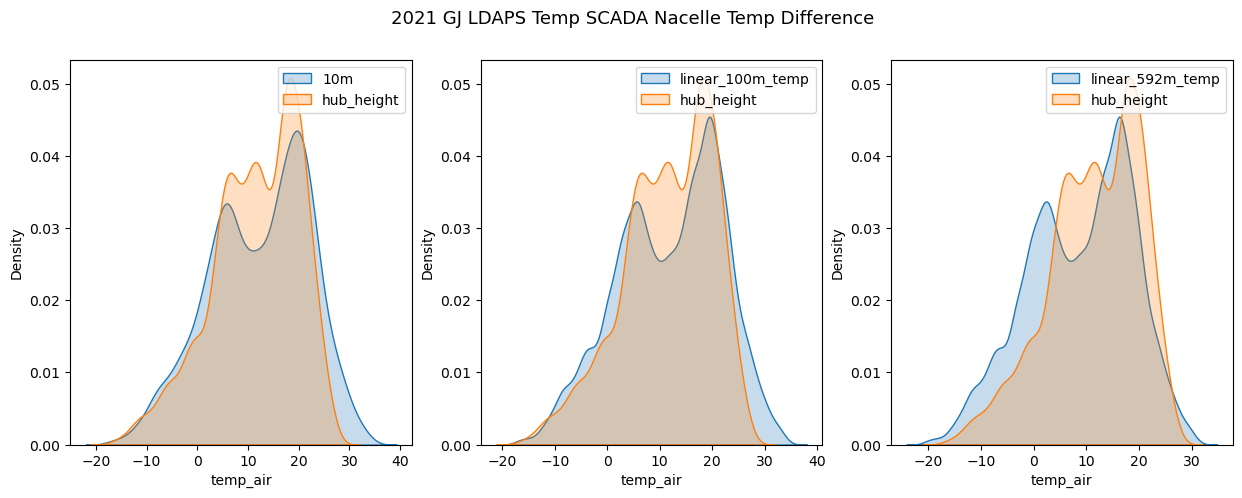

In [167]:
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 3, 1)
sns.kdeplot(x=tmp['temp_air'] - 273.15, label='10m',
            fill=True, ax=ax1)
sns.kdeplot(data=tmp,
            x='NacelleOutdoorTemp[℃]', label='hub_height',
            fill=True, ax=ax1)
ax1.legend()

hub_temperature = linear_gradient(ldaps['temp_air'], 0, 100)

ax2 = plt.subplot(1, 3, 2)
sns.kdeplot(x=hub_temperature - 273.15, label='linear_100m_temp',
            fill=True, ax=ax2)
sns.kdeplot(data=tmp,
            x='NacelleOutdoorTemp[℃]', label='hub_height',
            fill=True, ax=ax2)
ax2.legend()

hub_temperature = linear_gradient(ldaps['temp_air'], 0, 492 + 100)

ax3 = plt.subplot(1, 3, 3)
sns.kdeplot(x=hub_temperature - 273.15, label='linear_592m_temp',
            fill=True, ax=ax3)
sns.kdeplot(data=tmp,
            x='NacelleOutdoorTemp[℃]', label='hub_height',
            fill=True, ax=ax3)
ax3.legend()

plt.suptitle("2021 GJ LDAPS Temp SCADA Nacelle Temp Difference", fontsize=13)
plt.show()

# 영광풍력

In [52]:
from windpowerlib.temperature import linear_gradient

power = pd.read_parquet(INPUT_PATH + "dynamic_report_ewp004_202001_202007.parquet").rename({'Date/Time': 'dt'}, axis=1)
power2 = pd.read_parquet(INPUT_PATH + "dynamic_report_ewp004_202008_202012.parquet").rename({'Date/Time': 'dt'}, axis=1)
yg_y = pd.read_parquet(INPUT_PATH + "train_y.parquet").rename({'end_datetime': 'dt'}, axis=1)
ldaps = pd.read_parquet(INPUT_PATH + "train_ldaps_yeonggwang_ver2.parquet")

print("Power: ", power.shape)
print("train_y: ", yg_y.shape)
print("LDAPS: ", ldaps.shape)

Power:  (30178, 30)
train_y:  (52608, 4)
LDAPS:  (917070, 16)


In [53]:
# data slicing
power, power2 = power[:-3], power2[:-3]

power = pd.concat([power, power2], axis=0)

datas = [power, yg_y, ldaps]
for d in datas:
    try:
        d['dt'] = (pd.to_datetime(d['dt'])
                    .dt
                    .tz_convert("Asia/Seoul"))
    except TypeError:
        d['dt'] = (pd.to_datetime(d['dt'])
                    .dt
                    .tz_localize("Asia/Seoul"))

yg_y = (yg_y.loc[(yg_y['plant_name'] == "영광풍력")
                 & (yg_y['dt']).between('2020-01-01', '2021-01-01', inclusive='left')])

ldaps = ldaps.loc[ldaps['dt'].between('2020-01-01', '2021-01-01', inclusive='left')]

print("Power: ", power.shape, power['dt'].min(), power['dt'].max())
print("train_y: ", yg_y.shape, yg_y['dt'].min(), yg_y['dt'].max())
print("LDAPS: ", ldaps.shape, ldaps['dt'].min(), ldaps['dt'].max())

Power:  (51583, 30) 2020-01-01 00:00:00+09:00 2020-12-31 23:50:00+09:00
train_y:  (8783, 4) 2020-01-01 01:00:00+09:00 2020-12-31 23:00:00+09:00
LDAPS:  (306600, 16) 2020-01-02 00:00:00+09:00 2020-12-31 23:00:00+09:00


In [54]:
ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(
    ldaps["wind_u_10m"], ldaps["wind_v_10m"]
)

power.rename({'WTG.Name': 'turbine_id'}, axis=1, inplace=True)

tmp = pd.merge(yg_y, power,
               how='inner', on=['dt'])

tmp = pd.merge(tmp, ldaps,
               how='inner', on=['dt', 'turbine_id'])

tmp.head()

C:\Users\jhk32\AppData\Local\Temp\ipykernel_15668\1317439721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(
C:\Users\jhk32\AppData\Local\Temp\ipykernel_15668\1317439721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(


plant_name                        dt  period_hours  energy_kwh turbine_id  \
0       영광풍력 2020-01-02 00:00:00+09:00             1       0.000      WTG01   
1       영광풍력 2020-01-02 01:00:00+09:00             1      40.931      WTG01   
2       영광풍력 2020-01-02 02:00:00+09:00             1     185.493      WTG01   
3       영광풍력 2020-01-02 03:00:00+09:00             1      16.287      WTG01   
4       영광풍력 2020-01-02 04:00:00+09:00             1       0.000      WTG01   

  WTG.Serial  AvailabilityForcedOutageTime[Min.]  \
0   U113-001                                 0.0   
1   U113-001                                 0.0   
2   U113-001                                 0.0   
3   U113-001                                 0.0   
4   U113-001                                 0.0   

   AvailabilityRequestedShutdownTime[Min.]  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   AvailabilityScheduledMaintenanceTime[Min.]  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   

   AvailabilityTechnicalStandbyTime[Min.]  ...  relative_humid  \
0                                     0.0  ...       61.177334   
1                                     0.0  ...       61.698036   
2                                     0.0  ...       62.101166   
3                                     0.0  ...       61.944283   
4                                     0.0  ...       61.080189   

   specific_humid    temp_air  storm_u_5m  storm_v_5m  wind_u_10m  wind_v_10m  \
0        0.003413  280.260773    0.028556   -0.041619    2.841913   -4.775259   
1        0.003413  280.260681    0.042130   -0.044463    3.091386   -3.758680   
2        0.003418  280.268921    0.034533   -0.028805    3.005262   -3.511989   
3        0.003418  280.276672    0.025693   -0.028163    2.610194   -3.798681   
4        0.003418  280.266052    0.036102   -0.031177    2.678841   -3.966148   

   Night  wind_speed  wind_direction  
0      1    5.556939      329.241730  
1      1    4.866656      320.563873  
2      1    4.622301      319.445862  
3      1    4.609023      325.505798  
4      1    4.786076      325.963867  

[5 rows x 49 columns]

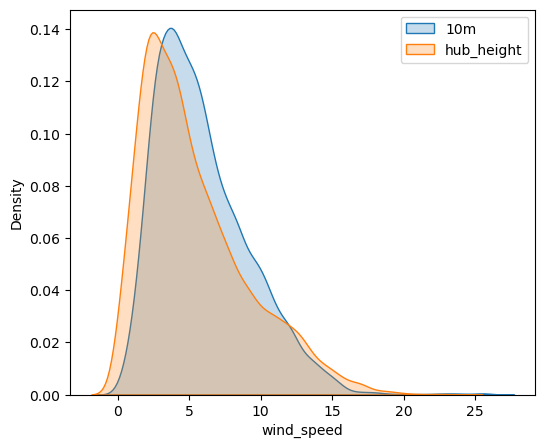

In [55]:
plt.figure(figsize=(6, 5))
sns.kdeplot(data=tmp,
            x='wind_speed', label='10m',
            fill=True)
sns.kdeplot(data=tmp,
            x='NacelleWindSpeed[m/s]', label='hub_height',
            fill=True)
plt.legend()
plt.show()
# 영광풍력의 경우 풍속보정은 크게 필요없을듯 함.

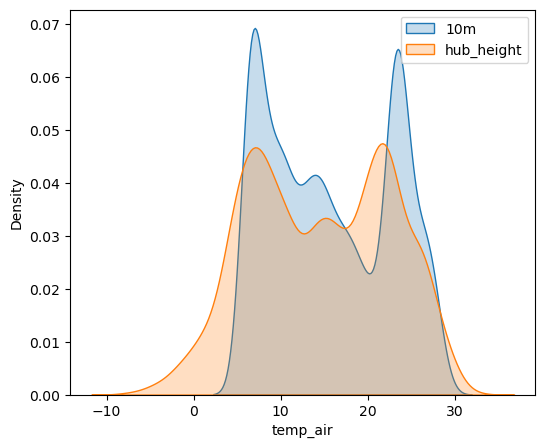

In [56]:
plt.figure(figsize=(6, 5))
sns.kdeplot(x=tmp['temp_air'] - 273.15, label='10m',
            fill=True)
sns.kdeplot(data=tmp,
            x='NacelleOutdoorTemp[℃]', label='hub_height',
            fill=True)

plt.legend()
plt.show()

In [134]:
tmp['wind_shear'] = (np.log1p(tmp['NacelleWindSpeed[m/s]']) - np.log1p(tmp['wind_speed']))/(np.log(100)-np.log(10))
tmp['turbulence_intensity'] = (tmp['wind_speed'] - tmp['wind_speed'].mean())/tmp['wind_speed'].mean()


In [140]:
tmp[['wind_shear', 'turbulence_intensity','EnergyProductionActiveEnergyProduction[KWh]']].corr()

wind_shear  turbulence_intensity  \
wind_shear                                     1.000000             -0.044179   
turbulence_intensity                          -0.044179              1.000000   
EnergyProductionActiveEnergyProduction[KWh]    0.412188              0.724020   

                                             EnergyProductionActiveEnergyProduction[KWh]  
wind_shear                                                                      0.412188  
turbulence_intensity                                                            0.724020  
EnergyProductionActiveEnergyProduction[KWh]                                     1.000000

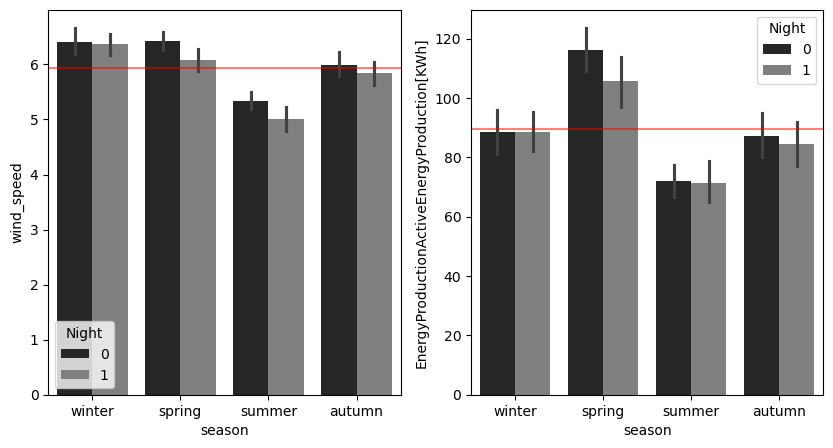

In [110]:
tmp['season'] = (tmp['dt'].dt.month % 12 // 3 + 1).map({
    1: 'winter',
    2: 'spring',
    3: 'summer',
    4: 'autumn' 
})

plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 2, 1)
sns.barplot(data=tmp,
            x='season',y='wind_speed',
            hue='Night',
            palette='dark:gray',
            ax=ax1)
ax1.axhline(y=tmp['wind_speed'].mean(), color='red', alpha=0.5)

ax2 = plt.subplot(1, 2, 2)
sns.barplot(data=tmp,
            x='season', y='EnergyProductionActiveEnergyProduction[KWh]',
            hue='Night',
            palette='dark:gray',
            ax=ax2)
ax2.axhline(y=tmp['EnergyProductionActiveEnergyProduction[KWh]'].mean(),
             color='red', 
             alpha=0.5)

plt.show()

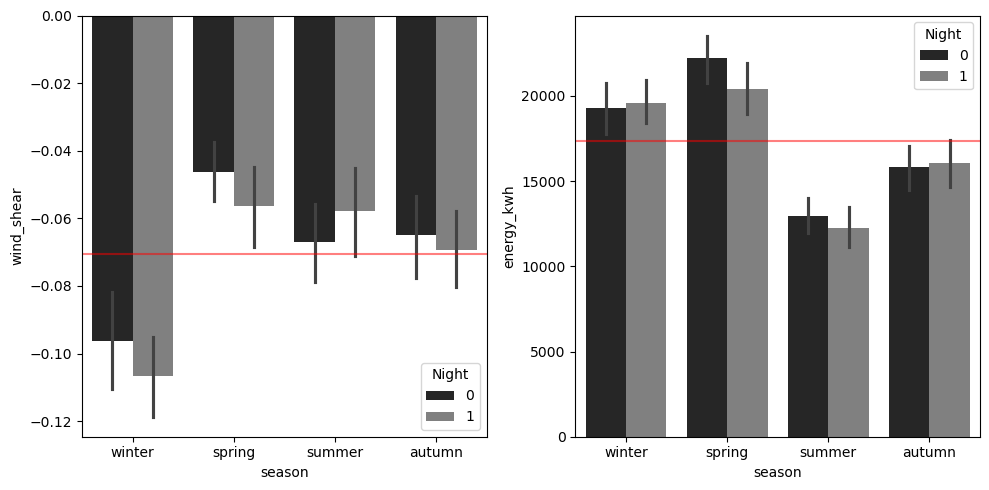

In [117]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 2, 1)
sns.barplot(data=tmp,
            x='season',y='wind_shear',
            hue='Night',
            palette='dark:gray',
            ax=ax1)
ax1.axhline(y=tmp['wind_shear'].mean(), color='red', alpha=0.5)

ax2 = plt.subplot(1, 2, 2)
sns.barplot(data=tmp,
            x='season', y='energy_kwh',
            hue='Night',
            palette='dark:gray',
            ax=ax2)
ax2.axhline(y=tmp['energy_kwh'].mean(), 
            color='red', 
            alpha=0.5,
            label='mean')
plt.tight_layout()
plt.show()

In [147]:
def calculate_tke(u, v, average_periods=3):
    pass

In [141]:
u_fluc = tmp['wind_u_10m'] - tmp['wind_u_10m'].mean()
v_fluc = tmp['wind_v_10m'] - tmp['wind_v_10m'].mean()

u_mean = (u_fluc ** 2).rolling(3, min_periods=1).mean()
v_mean = (v_fluc ** 2).rolling(3, min_periods=1).mean()

tmp['tke'] = (u_mean + v_mean)*0.5
tmp['tke'].describe()

count    8576.000000
mean       21.568031
std        24.630865
min         0.063883
25%         5.987231
50%        12.778768
75%        29.033104
max       283.194110
Name: tke, dtype: float64

In [142]:
tmp[['tke', 'energy_kwh']].corr()

tke  energy_kwh
tke         1.000000    0.676224
energy_kwh  0.676224    1.000000

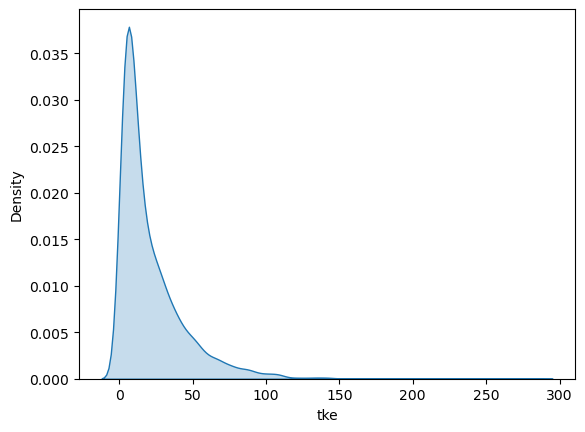

In [145]:
sns.kdeplot(data=tmp,
            x='tke',
            fill=True)
plt.show()

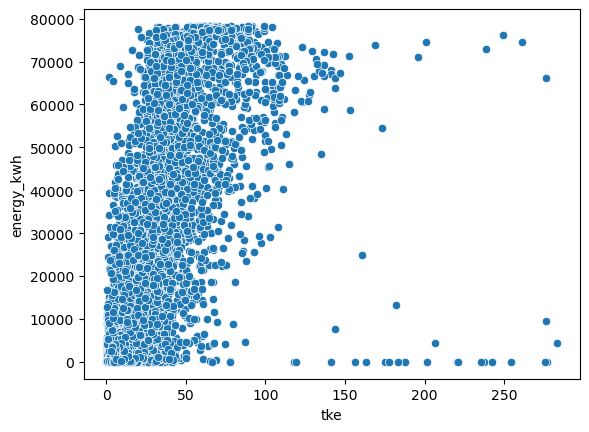

In [144]:
sns.scatterplot(data=tmp,
                x='tke',
                y='energy_kwh')

plt.show()

In [112]:
tmp['stability'] = pd.cut(tmp['wind_shear'], bins=[-np.inf, 0.0, 0.1, 0.2, 0.3, np.inf],
                          labels=['SC', 'C', 'N', 'S', 'SS'])

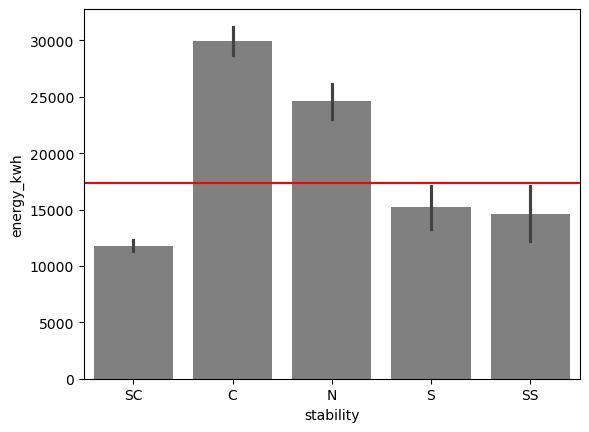

In [122]:
sns.barplot(data=tmp,
            x='stability', y='energy_kwh',
            color='gray'
            )
plt.axhline(y=tmp['energy_kwh'].mean(), color='red')
plt.show()

In [130]:
tmp.pivot_table(index='season', columns='stability', values='energy_kwh', aggfunc='mean')

stability            SC             C             N             S  \
season                                                              
autumn      8629.553790  29901.219687  24596.754223  15522.523734   
spring     15458.722878  33443.843295  29274.486904  21524.025811   
summer      7608.866029  20955.497320  21385.602225  12230.340934   
winter     14814.794689  36602.298879  22801.737133  11844.292439   

stability            SS  
season                   
autumn     15720.947690  
spring     18012.667857  
summer     12250.025327  
winter     13189.285429

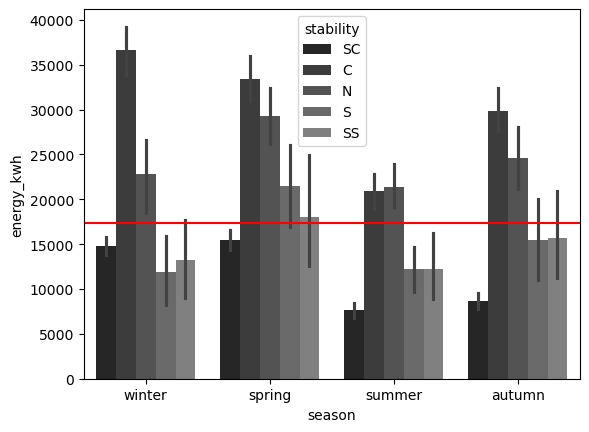

In [124]:
sns.barplot(data=tmp,
            x='season', y='energy_kwh',
            hue='stability',
            palette='dark:gray'
            )
plt.axhline(y=tmp['energy_kwh'].mean(), color='red')
plt.show()

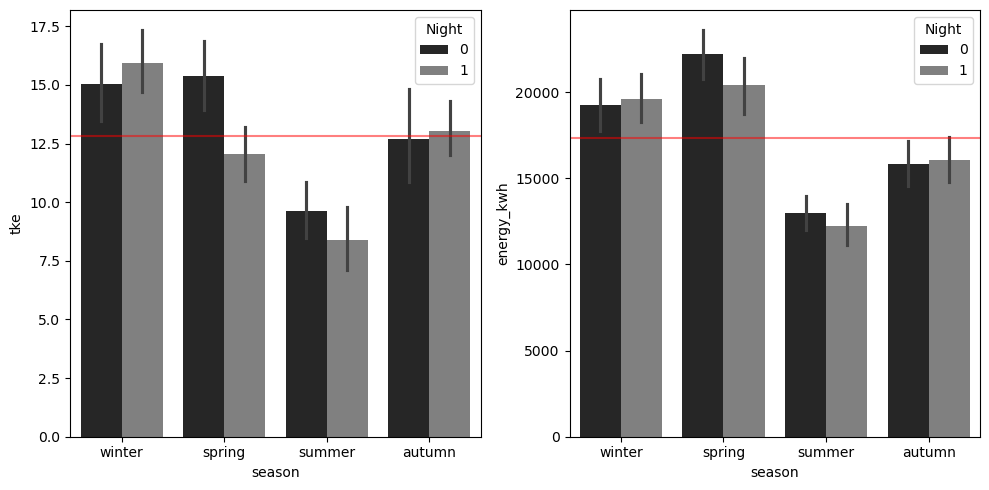

In [120]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 2, 1)
sns.barplot(data=tmp,
            x='season',y='tke',
            hue='Night',
            palette='dark:gray',
            ax=ax1)
ax1.axhline(y=tmp['tke'].mean(), color='red', alpha=0.5)

ax2 = plt.subplot(1, 2, 2)
sns.barplot(data=tmp,
            x='season', y='energy_kwh',
            hue='Night',
            palette='dark:gray',
            ax=ax2)
ax2.axhline(y=tmp['energy_kwh'].mean(), 
            color='red', 
            alpha=0.5,
            label='mean')
plt.tight_layout()
plt.show()

In [14]:
path = "C:/Users/jhk32/Downloads/공모전 제공용 데이터 및 예제/3-2. 분석용데이터_경주풍력_SCADA"

ldaps = pd.read_parquet(INPUT_PATH + "train_ldaps_gyeongju.parquet")
coef = []

for i in range(9):
    power = (pd.read_excel(path + "/dynamic_report_ewp02_2020_10min.xlsx", index_col = None, sheet_name = i, header = 5)
            .rename(columns = {'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}))[:-3]
    
    try:
        power['dt'] = (pd.to_datetime(power['dt'])
                       .dt
                       .tz_convert("Asia/Seoul"))
    except TypeError:
        power['dt'] = (pd.to_datetime(power['dt'])
                       .dt
                       .tz_localize("Asia/Seoul"))
    
    tmp = pd.merge(ldaps, power, how='inner', on='dt')
    del power

    wind_speed = tmp['Nacelle\nWind Speed\n[m/s]']
    density = tmp['Nacelle\nAir Density\n[kg/㎥]']

    ideal_energy =(wind_speed ** 3) * density * 0.5

    actual_energy = tmp['Energy Production\nActive Energy Production\n[KWh]']

    coef.append((actual_energy / ideal_energy).mean())
    
    print(f"WTG_{i+1}")
    print((actual_energy / ideal_energy).mean())
    print('-'*50)

c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_1
0.305794493928852
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_2
0.3089340699339628
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_3
0.31557965054408693
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_4
0.29964520946771056
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_5
0.29195352687005827
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_6
0.30593263159714534
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_7
0.32353519236699796
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_8
0.3082446219588647
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_9
0.29595544291319625
--------------------------------------------------


In [15]:
# 경주풍력
efficiency = [0.305794493928852, 0.3089340699339628, 0.31557965054408693, 0.29964520946771056, 0.29195352687005827,
              0.30593263159714534, 0.32353519236699796, 0.3082446219588647, 0.29595544291319625]

print(np.mean(efficiency))
print(np.std(efficiency))

0.30617498217565275
0.009136318670074561


In [25]:
path = "C:/Users/jhk32/Downloads/공모전 제공용 데이터 및 예제/3-1. 분석용데이터_영광풍력_SCADA/"

ldaps = pd.read_parquet(INPUT_PATH + "train_ldaps_gyeongju.parquet")
coef = []

for i in range(16):
    power = (pd.read_excel(path + "dynamic_report_ewp004_202001_202007.xlsx", index_col = None, sheet_name = i, header = 5)
            .rename(columns = {'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}))
    
    idx = power.loc[power['dt'].isin(['Summation', 'Average', 'Standard Deviation'])].index
    power.drop(idx, axis=0, inplace=True)
    
    try:
        power['dt'] = (pd.to_datetime(power['dt'])
                       .dt
                       .tz_convert("Asia/Seoul"))
    except TypeError:
        power['dt'] = (pd.to_datetime(power['dt'])
                       .dt
                       .tz_localize("Asia/Seoul"))
    
    tmp = pd.merge(ldaps, power, how='inner', on='dt')
    del power

    wind_speed = tmp['Nacelle\nWind Speed\n[m/s]']
    density = tmp['Nacelle\nAir Density\n[kg/㎥]']

    ideal_energy =(wind_speed ** 3) * density * 0.5

    actual_energy = tmp['Energy Production\nActive Energy Production\n[KWh]']

    coef.append((actual_energy / ideal_energy).mean())
    
    print(f"WTG_{i+1}")
    print((actual_energy / ideal_energy).mean())
    print('-'*50)

WTG_1
0.36505007283843577
--------------------------------------------------
WTG_2
0.3851103938892046
--------------------------------------------------
WTG_3
0.3613393161050932
--------------------------------------------------
WTG_4
0.3420873503175273
--------------------------------------------------
WTG_5
0.33464826561629984
--------------------------------------------------
WTG_6
0.2990011479688867
--------------------------------------------------
WTG_7
0.28356355422459734
--------------------------------------------------
WTG_8
0.325821424189719
--------------------------------------------------
WTG_9
0.27211136308199735
--------------------------------------------------
WTG_10
0.2902640940839886
--------------------------------------------------
WTG_11
0.26549819422799986
--------------------------------------------------
WTG_12
0.2655801863898029
--------------------------------------------------
WTG_13
0.27960889196832717
--------------------------------------------------
WTG

In [27]:
coef_0107 = coef
print(np.mean(coef_0107))
print(np.std(coef_0107))

0.30197165013028093
0.042830999232251005


In [28]:
path = "C:/Users/jhk32/Downloads/공모전 제공용 데이터 및 예제/3-1. 분석용데이터_영광풍력_SCADA/"

ldaps = pd.read_parquet(INPUT_PATH + "train_ldaps_gyeongju.parquet")
coef = []

for i in range(16):
    power = (pd.read_excel(path + "dynamic_report_ewp004_202008_202012.xlsx", index_col = None, sheet_name = i, header = 5)
            .rename(columns = {'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}))
    
    idx = power.loc[power['dt'].isin(['Summation', 'Average', 'Standard Deviation'])].index
    power.drop(idx, axis=0, inplace=True)
    
    try:
        power['dt'] = (pd.to_datetime(power['dt'])
                       .dt
                       .tz_convert("Asia/Seoul"))
    except TypeError:
        power['dt'] = (pd.to_datetime(power['dt'])
                       .dt
                       .tz_localize("Asia/Seoul"))
    
    tmp = pd.merge(ldaps, power, how='inner', on='dt')
    del power

    wind_speed = tmp['Nacelle\nWind Speed\n[m/s]']
    density = tmp['Nacelle\nAir Density\n[kg/㎥]']

    ideal_energy =(wind_speed ** 3) * density * 0.5

    actual_energy = tmp['Energy Production\nActive Energy Production\n[KWh]']

    coef.append((actual_energy / ideal_energy).mean())
    
    print(f"WTG_{i+1}")
    print((actual_energy / ideal_energy).mean())
    print('-'*50)

c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_1
0.3540727320298157
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_2
0.3585313548629922
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_3
0.34583532992856836
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_4
0.3491808348031303
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_5
0.34558147019547575
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_6
0.33881063536833317
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_7
0.30883808716504785
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_8
0.25884714525188485
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_9
0.2613911554515104
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_10
0.27310337399682694
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_11
0.13647519820374432
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_12
0.16946438573610503
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_13
0.17534187253593
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_14
0.16993042271393458
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_15
0.1362721296690232
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_16
0.14675929779947852
--------------------------------------------------


In [29]:
print(np.mean(coef))
print(np.std(coef))

0.2580272141069876
0.08543229468349157


Text(0.5, 1.0, '08-12')

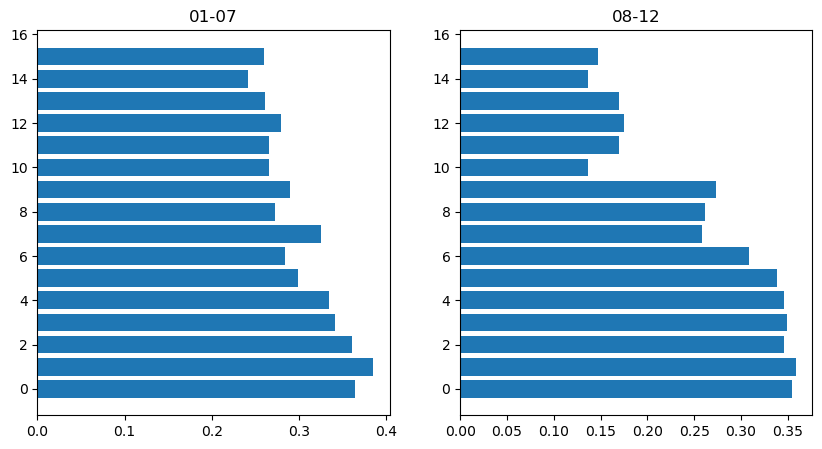

In [40]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 2, 1)
ax1.barh(y=[i for i in range(16)],
         width=coef_0107)
ax1.set_title("01-07")

ax2 = plt.subplot(1, 2, 2)
ax2.barh(y=[i for i in range(16)],
         width=coef)
ax2.set_title("08-12")

In [63]:
path = "C:/Users/jhk32/Downloads/공모전 제공용 데이터 및 예제/3-1. 분석용데이터_영광풍력_SCADA/"

ldaps = pd.read_parquet(INPUT_PATH + "train_ldaps_yeonggwang.parquet")
coef = []

for i in range(16):
    power1 = (pd.read_excel(path + "dynamic_report_ewp004_202001_202007.xlsx", index_col = None, sheet_name = i, header = 5)
            .rename(columns = {'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}));
    power2 = (pd.read_excel(path + "dynamic_report_ewp004_202008_202012.xlsx", index_col = None, sheet_name = i, header = 5)
                .rename(columns = {'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}));
    power3 = (pd.read_excel(path + "dynamic_report_ewp004_202101_202106.xlsx", index_col = None, sheet_name = i, header = 5)
                .rename(columns = {'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}));
    power4 = (pd.read_excel(path + "dynamic_report_ewp004_202107_202112.xlsx", index_col = None, sheet_name = i, header = 5)
                .rename(columns = {'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}));
    power5 = (pd.read_excel(path + "dynamic_report_ewp004_202201_202206.xlsx", index_col = None, sheet_name = i, header = 5)
                .rename(columns = {'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}));
    power6 = (pd.read_excel(path + "dynamic_report_ewp004_202207_202212.xlsx", index_col = None, sheet_name = i, header = 5)
                .rename(columns = {'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}));

    power = pd.concat([power1, power2, power3, power4, power5, power6], axis=0)
    
    idx = power.loc[power['dt'].isin(['Summation', 'Average', 'Standard Deviation'])].index
    power.drop(idx, axis=0, inplace=True)
    
    try:
        power['dt'] = (pd.to_datetime(power['dt'])
                       .dt
                       .tz_convert("Asia/Seoul"))
    except TypeError:
        power['dt'] = (pd.to_datetime(power['dt'])
                       .dt
                       .tz_localize("Asia/Seoul"))
    
    tmp = pd.merge(ldaps, power, how='inner', on='dt')
    del power

    wind_speed = tmp['Nacelle\nWind Speed\n[m/s]']
    density = tmp['Nacelle\nAir Density\n[kg/㎥]']

    ideal_energy =(wind_speed ** 3) * density * 0.5

    actual_energy = tmp['Energy Production\nActive Energy Production\n[KWh]']

    coef.append((actual_energy / ideal_energy).mean())
    
    print(f"WTG_{i+1}")
    print((actual_energy / ideal_energy).mean())
    print('-'*50)

c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_1
0.35268551264093945
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_2
0.3538937276925238
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_3
0.30505058477731
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_4
0.30716929665389836
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_5
0.31809591695620926
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_6
0.3013505207170271
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_7
0.26846637411074264
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_8
0.3008783456515474
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_9
0.2696447091673925
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_10
0.27417021360051613
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_11
0.25183248829266275
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_12
0.2577677185111081
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_13
0.24939145865732423
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_14
0.25407783222088026
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_15
0.2388678557767508
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_16
0.24015131118709804
--------------------------------------------------


In [67]:
pd.DataFrame(data=coef, index=[i+1 for i in range(len(coef))], columns=['efficiency_coef'])

efficiency_coef
1          0.352686
2          0.353894
3          0.305051
4          0.307169
5          0.318096
6          0.301351
7          0.268466
8          0.300878
9          0.269645
10         0.274170
11         0.251832
12         0.257768
13         0.249391
14         0.254078
15         0.238868
16         0.240151

In [103]:
path = "C:/Users/jhk32/Downloads/공모전 제공용 데이터 및 예제/3-2. 분석용데이터_경주풍력_SCADA/"

ldaps = pd.read_parquet(INPUT_PATH + "train_ldaps_gyeongju.parquet")
coef = []

for i in range(9):
    power1 = (pd.read_excel(path + "dynamic_report_ewp02_2020_10min.xlsx", index_col = None, sheet_name = i, header = 5)
            .rename(columns = {'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}));
    power2 = (pd.read_excel(path + "dynamic_report_ewp02_2021_10min.xlsx", index_col = None, sheet_name = i, header = 5)
            .rename(columns = {'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}));
    power3 = (pd.read_excel(path + "dynamic_report_ewp02_2022_10min.xlsx", index_col = None, sheet_name = i, header = 5)
            .rename(columns = {'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}));
    
    power = pd.concat([power1, power2, power3], axis=0)
    
    idx = power.loc[power['dt'].isin(['Summation', 'Average', 'Standard Deviation'])].index
    power.drop(idx, axis=0, inplace=True)
    
    try:
        power['dt'] = (pd.to_datetime(power['dt'])
                       .dt
                       .tz_convert("Asia/Seoul"))
    except TypeError:
        power['dt'] = (pd.to_datetime(power['dt'])
                       .dt
                       .tz_localize("Asia/Seoul"))
    
    tmp = pd.merge(ldaps[ldaps['turbine_id'].str.slice(3, 5).astype(int) == i+1], power, how='inner', on='dt')
    del power

    wind_speed = tmp['Nacelle\nWind Speed\n[m/s]']
    density = tmp['Nacelle\nAir Density\n[kg/㎥]']

    ideal_energy =(wind_speed ** 3) * density * 0.5

    actual_energy = tmp['Energy Production\nActive Energy Production\n[KWh]']

    coef.append((actual_energy / ideal_energy).mean())
    
    print(f"WTG_{i+1}")
    print((actual_energy / ideal_energy).mean())
    print('-'*50)

c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_1
0.26787736651855737
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_2
0.3144495447599224
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_3
0.36020264694742865
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_4
0.3253187401810253
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_5
0.24555568041924516
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_6
0.32113456268391055
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_7
0.33280153963159315
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_8
0.3110062719495197
--------------------------------------------------


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


WTG_9
0.29243188151207355
--------------------------------------------------


: 

In [71]:
pd.DataFrame(data=coef, index=[i+1 for i in range(len(coef))], columns=['efficiency_coef']).to_pickle("gj_coef")

efficiency_coef
1         0.267877
2         0.314450
3         0.360203
4         0.325319
5         0.245556
6         0.321135
7         0.332802
8         0.311006
9         0.292432

In [74]:
y = pd.read_parquet("../input/train_y.parquet")
y.head()

plant_name               end_datetime  period_hours   energy_kwh
0       경주풍력  2020-01-01T01:00:00+09:00             1  9767.578125
1       경주풍력  2020-01-01T02:00:00+09:00             1  5381.835938
2       경주풍력  2020-01-01T03:00:00+09:00             1  3021.484375
3       경주풍력  2020-01-01T04:00:00+09:00             1  4400.390625
4       경주풍력  2020-01-01T05:00:00+09:00             1  4501.953125

In [8]:
tmp = pd.merge(ldaps[ldaps['turbine_id'] == 'WTG01'], power, how='left', on=['dt'])
tmp

dt   elevation  land_cover  surf_rough  \
0    2020-01-02 00:00:00+09:00  387.640625         1.0    0.286911   
1    2020-01-02 01:00:00+09:00  387.640625         1.0    0.286911   
2    2020-01-02 02:00:00+09:00  387.640625         1.0    0.286911   
3    2020-01-02 03:00:00+09:00  387.640625         1.0    0.286911   
4    2020-01-02 04:00:00+09:00  387.640625         1.0    0.286911   
...                        ...         ...         ...         ...   
8755 2020-12-31 19:00:00+09:00  387.640625         1.0    0.286911   
8756 2020-12-31 20:00:00+09:00  387.640625         1.0    0.286911   
8757 2020-12-31 21:00:00+09:00  387.640625         1.0    0.286911   
8758 2020-12-31 22:00:00+09:00  387.640625         1.0    0.286911   
8759 2020-12-31 23:00:00+09:00  387.640625         1.0    0.286911   

      frictional_vmax_50m  frictional_vmin_50m      pressure  relative_humid  \
0               10.428498            10.059580  97974.593750       91.796478   
1               10.472921            10.044404  97970.132812       91.729774   
2               10.682985            10.478634  97951.546875       92.788666   
3               10.676681            10.090029  97908.968750       92.494576   
4               10.079557             9.672620  97858.398438       88.986443   
...                   ...                  ...           ...             ...   
8755            10.441029             9.678152  97361.718750       65.901024   
8756             9.671831             8.727891  97391.875000       72.660370   
8757             8.698429             8.168437  97381.054688       81.252159   
8758             8.166893             6.673002  97366.976562       91.036568   
8759             6.937514             6.488052  97361.335938       96.942932   

      specific_humid    temp_air  ...  RotorBlade2Pos.[deg]  \
0           0.002686  269.467560  ...             12.885867   
1           0.002686  269.430847  ...             15.051033   
2           0.002686  269.374390  ...             11.442700   
3           0.002686  269.352112  ...             14.859333   
4           0.002686  269.413269  ...             11.268133   
...              ...         ...  ...                   ...   
8755        0.001465  265.449219  ...              0.753400   
8756        0.001465  264.996765  ...              2.446067   
8757        0.001709  264.703735  ...              0.066400   
8758        0.001709  264.253967  ...              0.180100   
8759        0.001953  264.051208  ...              1.181167   

      RotorBlade3Pos.[deg]  RotorMotor1Pos.[deg]  RotorMotor2Pos.[deg]  \
0                12.852400             12.751966             12.750267   
1                15.012667             14.927600             14.928033   
2                11.413700             11.305433             11.305866   
3                14.840734             14.724400             14.724767   
4                11.237400             11.125566             11.125800   
...                    ...                   ...                   ...   
8755              0.906067              0.818000              0.817833   
8756              2.597933              2.529000              2.529033   
8757              0.223133              0.119167              0.119333   
8758              0.364500              0.240200              0.240100   
8759              1.334433              1.228500              1.228600   

     RotorMotor3Pos.[deg] RotorPitch1Angle[deg] RotorPitch2Angle[deg]  \
0               12.749833             12.750566             12.753667   
1               14.927700             14.927600             14.928100   
2               11.305866             11.305433             11.305866   
3               14.724733             14.724167             14.725067   
4               11.125767             11.125600             11.125800   
...                   ...                   ...                   ...   
8755             0.817800              0.818000              0.817833

In [27]:
0.267877 + 0.314450 + 0.360203 + 0.325319 + 0.245556 + 0.321135 + 0.332802 + 0.311006 + 0.292432

2.7707800000000002

In [10]:
tmp['density'] = (tmp['pressure'])/(tmp['temp_air'] * 287)

tmp.head()

dt   elevation  land_cover  surf_rough  \
0 2020-01-02 00:00:00+09:00  387.640625         1.0    0.286911   
1 2020-01-02 01:00:00+09:00  387.640625         1.0    0.286911   
2 2020-01-02 02:00:00+09:00  387.640625         1.0    0.286911   
3 2020-01-02 03:00:00+09:00  387.640625         1.0    0.286911   
4 2020-01-02 04:00:00+09:00  387.640625         1.0    0.286911   

   frictional_vmax_50m  frictional_vmin_50m      pressure  relative_humid  \
0            10.428498            10.059580  97974.593750       91.796478   
1            10.472921            10.044404  97970.132812       91.729774   
2            10.682985            10.478634  97951.546875       92.788666   
3            10.676681            10.090029  97908.968750       92.494576   
4            10.079557             9.672620  97858.398438       88.986443   

   specific_humid    temp_air  ...  RotorBlade3Pos.[deg]  \
0        0.002686  269.467560  ...             12.852400   
1        0.002686  269.430847  ...             15.012667   
2        0.002686  269.374390  ...             11.413700   
3        0.002686  269.352112  ...             14.840734   
4        0.002686  269.413269  ...             11.237400   

   RotorMotor1Pos.[deg]  RotorMotor2Pos.[deg]  RotorMotor3Pos.[deg]  \
0             12.751966             12.750267             12.749833   
1             14.927600             14.928033             14.927700   
2             11.305433             11.305866             11.305866   
3             14.724400             14.724767             14.724733   
4             11.125566             11.125800             11.125767   

  RotorPitch1Angle[deg] RotorPitch2Angle[deg] RotorPitch3Angle[deg]  \
0             12.750566             12.753667             12.750800   
1             14.927600             14.928100             14.927700   
2             11.305433             11.305866             11.305866   
3             14.724167             14.725067             14.724733   
4             11.125600             11.125800             11.125767   

   RotorRotorSpeed[rpm]  YawYawcablewindup[deg]   density  
0             13.473317              380.510468  1.266850  
1             13.491118              384.135803  1.266965  
2             13.480920              384.135803  1.266990  
3             13.499493              384.135803  1.266544  
4             13.470323              384.135803  1.265602  

[5 rows x 44 columns]

In [11]:
tmp['wind_speed'], tmp['wind_direction'] = uv_to_wsd(tmp['wind_u_10m'], tmp['wind_v_10m'])

tmp['wind_speed_100m'] = logarithmic_profile(tmp['wind_speed'], 10, 100, tmp['surf_rough'])

In [37]:
tmp['wind_power_density'] = (0.5 * tmp['density'] * (tmp['wind_speed_100m'] ** 3)) * 0.267877 #* 2.7707800000000002

In [87]:
(0.5 * tmp['density'] * (tmp['wind_speed_100m'] ** 3)) * 0.267877

0       8699.395508
1       9178.478516
2       9274.325195
3       8083.816406
4       6726.635742
           ...     
8755    5398.879395
8756    3679.825195
8757    2953.471436
8758    1417.810425
8759    1691.211670
Length: 8760, dtype: float32

In [88]:
gj_y[23:-24]

plant_name                        dt  period_hours    energy_kwh
23         경주풍력 2020-01-02 00:00:00+09:00             1  20798.828125
24         경주풍력 2020-01-02 01:00:00+09:00             1  20798.828125
25         경주풍력 2020-01-02 02:00:00+09:00             1  20199.218750
26         경주풍력 2020-01-02 03:00:00+09:00             1  19357.421875
27         경주풍력 2020-01-02 04:00:00+09:00             1  20806.640625
...         ...                       ...           ...           ...
8754       경주풍력 2020-12-30 19:00:00+09:00             1  11121.093750
8755       경주풍력 2020-12-30 20:00:00+09:00             1  15951.171875
8756       경주풍력 2020-12-30 21:00:00+09:00             1  14968.750000
8757       경주풍력 2020-12-30 22:00:00+09:00             1  15566.406250
8758       경주풍력 2020-12-30 23:00:00+09:00             1  16513.671875

[8736 rows x 4 columns]

In [44]:
tmp['shear_stress'] = (tmp['frictional_vmax_50m'] ** 2) * tmp['density']

In [45]:
from scipy.stats import pearsonr
df = tmp.merge(gj_y, how='left', on='dt')

pearsonr(df['shear_stress'], df['energy_kwh'])

PearsonRResult(statistic=0.5742187570813073, pvalue=0.0)

In [46]:
pearsonr(df['wind_power_density'], df['energy_kwh'])

PearsonRResult(statistic=0.37930809848739677, pvalue=8.561706308488452e-298)

In [47]:
pearsonr(df['wind_speed_100m'], df['energy_kwh'])

PearsonRResult(statistic=0.6289458884339183, pvalue=0.0)

In [53]:
(0.5 * tmp['density'] * (tmp['wind_speed'] ** 3)) *  0.267877

0       4572.321289
1       4824.123535
2       4874.500488
3       4248.778809
4       3535.457031
           ...     
8755    2837.600342
8756    1934.081787
8757    1552.317261
8758     745.188110
8759     888.885254
Length: 8760, dtype: float32

In [83]:
logarithmic_profile(tmp['wind_v_10m'], 10, 100, tmp['surf_rough']).describe()

count    8760.000000
mean       -1.189694
std         5.011019
min       -19.313152
25%        -4.243213
50%        -2.067858
75%         1.628689
max        29.912621
dtype: float64

In [61]:
tmp['ke'] = 0.5 * tmp['wind_speed_100m'] ** 2

tmp['wind_u_100m'] = logarithmic_profile(tmp['wind_u_10m'], 10, 100, tmp['surf_rough'])
tmp['wind_v_100m'] = logarithmic_profile(tmp['wind_v_10m'], 10, 100, tmp['surf_rough'])

u_fluc = tmp['wind_u_100m'] - tmp['wind_u_100m'].mean()
v_fluc = tmp['wind_v_100m'] - tmp['wind_v_100m'].mean()

u_mean = (u_fluc ** 2).rolling(3, min_periods=1).mean()
v_mean = (v_fluc ** 2).rolling(3, min_periods=1).mean()

tmp['tke'] = (u_mean + v_mean) * 0.5

In [63]:
from scipy.stats import pearsonr
df = tmp.merge(gj_y, how='left', on='dt')

pearsonr(df['ke'], df['energy_kwh'])

PearsonRResult(statistic=0.5234130283626983, pvalue=0.0)

In [80]:
df['me'] = df['ke'] - df['tke']

In [82]:
pearsonr(df['me'], df['energy_kwh'])

PearsonRResult(statistic=0.5010502577427784, pvalue=0.0)

In [76]:
gj_y['energy_kwh'] = gj_y['energy_kwh'].shift(-24)

C:\Users\jhk32\AppData\Local\Temp\ipykernel_13676\3639158920.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gj_y['energy_kwh'] = gj_y['energy_kwh'].shift(-24)


In [79]:
gj_y[23:-24]

plant_name                        dt  period_hours    energy_kwh
23         경주풍력 2020-01-02 00:00:00+09:00             1  20798.828125
24         경주풍력 2020-01-02 01:00:00+09:00             1  20798.828125
25         경주풍력 2020-01-02 02:00:00+09:00             1  20199.218750
26         경주풍력 2020-01-02 03:00:00+09:00             1  19357.421875
27         경주풍력 2020-01-02 04:00:00+09:00             1  20806.640625
...         ...                       ...           ...           ...
8754       경주풍력 2020-12-30 19:00:00+09:00             1  11121.093750
8755       경주풍력 2020-12-30 20:00:00+09:00             1  15951.171875
8756       경주풍력 2020-12-30 21:00:00+09:00             1  14968.750000
8757       경주풍력 2020-12-30 22:00:00+09:00             1  15566.406250
8758       경주풍력 2020-12-30 23:00:00+09:00             1  16513.671875

[8736 rows x 4 columns]

In [90]:
df

dt   elevation  land_cover  surf_rough  \
0    2020-01-02 00:00:00+09:00  387.640625         1.0    0.286911   
1    2020-01-02 01:00:00+09:00  387.640625         1.0    0.286911   
2    2020-01-02 02:00:00+09:00  387.640625         1.0    0.286911   
3    2020-01-02 03:00:00+09:00  387.640625         1.0    0.286911   
4    2020-01-02 04:00:00+09:00  387.640625         1.0    0.286911   
...                        ...         ...         ...         ...   
8755 2020-12-31 19:00:00+09:00  387.640625         1.0    0.286911   
8756 2020-12-31 20:00:00+09:00  387.640625         1.0    0.286911   
8757 2020-12-31 21:00:00+09:00  387.640625         1.0    0.286911   
8758 2020-12-31 22:00:00+09:00  387.640625         1.0    0.286911   
8759 2020-12-31 23:00:00+09:00  387.640625         1.0    0.286911   

      frictional_vmax_50m  frictional_vmin_50m      pressure  relative_humid  \
0               10.428498            10.059580  97974.593750       91.796478   
1               10.472921            10.044404  97970.132812       91.729774   
2               10.682985            10.478634  97951.546875       92.788666   
3               10.676681            10.090029  97908.968750       92.494576   
4               10.079557             9.672620  97858.398438       88.986443   
...                   ...                  ...           ...             ...   
8755            10.441029             9.678152  97361.718750       65.901024   
8756             9.671831             8.727891  97391.875000       72.660370   
8757             8.698429             8.168437  97381.054688       81.252159   
8758             8.166893             6.673002  97366.976562       91.036568   
8759             6.937514             6.488052  97361.335938       96.942932   

      specific_humid    temp_air  ...  shear_stress  wind_power_density  \
0           0.002686  269.467560  ...    137.774445          362.474823   
1           0.002686  269.430847  ...    138.963318          382.436615   
2           0.002686  269.374390  ...    144.596695          386.430206   
3           0.002686  269.352112  ...    144.375229          336.825684   
4           0.002686  269.413269  ...    128.582001          280.276489   
...              ...         ...  ...           ...                 ...   
8755        0.001465  265.449219  ...    139.319351          224.953308   
8756        0.001465  264.996765  ...    119.789207          153.326050   
8757        0.001709  264.703735  ...     96.987144          123.061310   
8758        0.001709  264.253967  ...     85.629227           59.075436   
8759        0.001953  264.051208  ...     61.833553           70.467155   

             ke        tke wind_u_100m wind_v_100m plant_name  period_hours  \
0     82.934425  48.494806   12.121139   -4.352796       경주풍력             1   
1     85.946800  49.704470   12.492327   -3.979368       경주풍력             1   
2     86.542953  50.290324   12.617785   -3.725246       경주풍력             1   
3     78.987137  49.328939   11.993516   -3.758968       경주풍력             1   
4     69.913223  45.331041   11.393345   -3.165143       경주풍력             1   
...         ...        ...         ...         ...        ...           ...   
8755  59.989883  43.223938   10.938513    0.573304       경주풍력             1   
8756  46.399166  34.431744    9.619495    0.513451       경주풍력             1   
8757  40.045990  26.506330    8.943181    0.333909       경주풍력             1   
8758  24.526306  18.184423    7.002136    0.150724       경주풍력             1   
8759  27.572735  13.780936    7.425565    0.080408       경주풍력             1   

        energy_kwh         me  
0     17827.148438  34.439620  
1     17616.210938  36.242330  
2     17904.296875  36.252630  
3     17676.757812  29.658198  
4     18519.531250  24.582182  
...            ...        ...  
8755  11121.093750  16.765945  
8756  15951.171875  11.967422  
8757  14968.750000  13.539660  
8758  15566.406250   6.341883  
8759  16513.671875  13.7

In [93]:
list(df['energy_kwh'])

[17827.1484375,
 17616.2109375,
 17904.296875,
 17676.7578125,
 18519.53125,
 17486.328125,
 18265.625,
 16057.6171875,
 15183.59375,
 18288.0859375,
 18488.28125,
 18283.203125,
 16553.7109375,
 14019.53125,
 10613.28125,
 10773.4375,
 17417.96875,
 19138.671875,
 20355.46875,
 20697.265625,
 20789.0625,
 20805.6640625,
 20810.546875,
 20809.5703125,
 20798.828125,
 20798.828125,
 20199.21875,
 19357.421875,
 20806.640625,
 18753.90625,
 17553.7109375,
 17673.828125,
 18472.65625,
 18463.8671875,
 19873.046875,
 20811.5234375,
 20805.6640625,
 18252.9296875,
 19811.5234375,
 15992.1875,
 15292.96875,
 16748.046875,
 17240.234375,
 19688.4765625,
 20516.6015625,
 19767.578125,
 20028.3203125,
 18716.796875,
 20443.359375,
 20386.71875,
 19919.921875,
 20723.6328125,
 20820.3125,
 20783.203125,
 20680.6640625,
 17086.9140625,
 11522.4609375,
 14320.3125,
 17638.671875,
 19639.6484375,
 20760.7421875,
 20507.8125,
 20343.75,
 19815.4296875,
 19638.671875,
 17547.8515625,
 16246.09375,
 1

c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


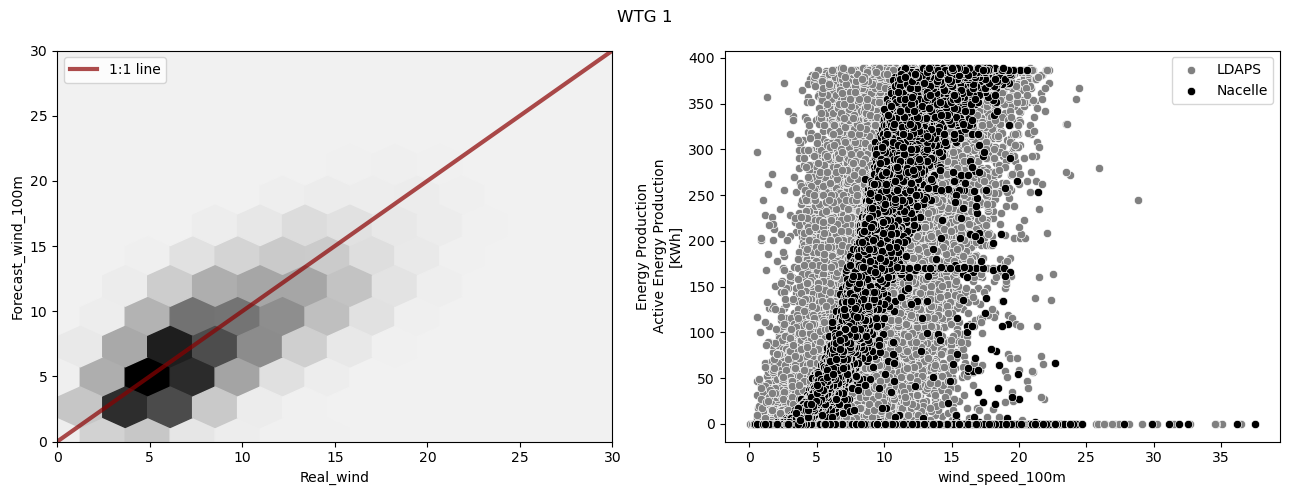

c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


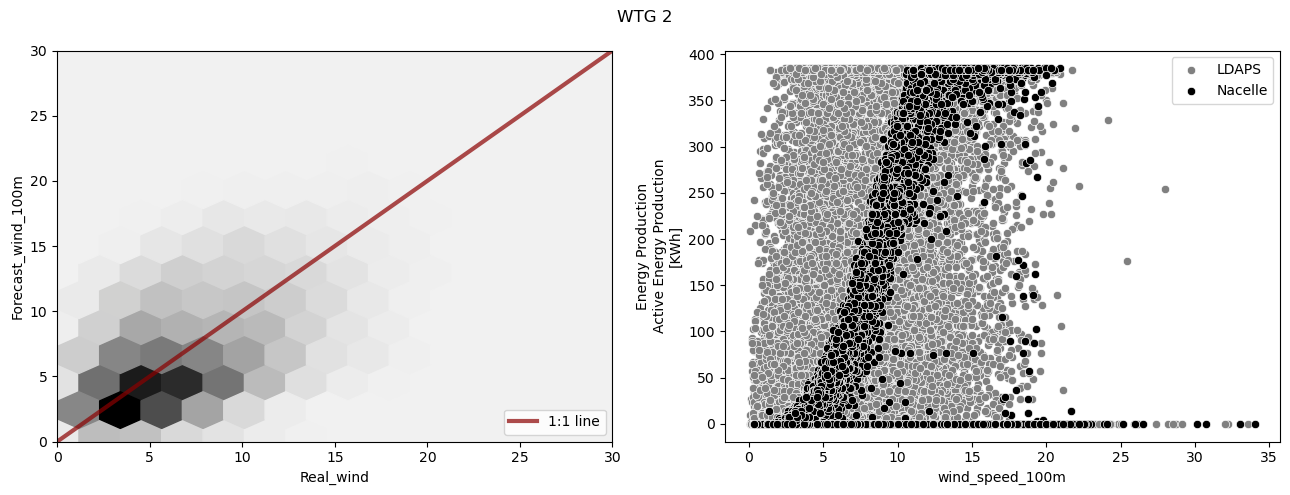

c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


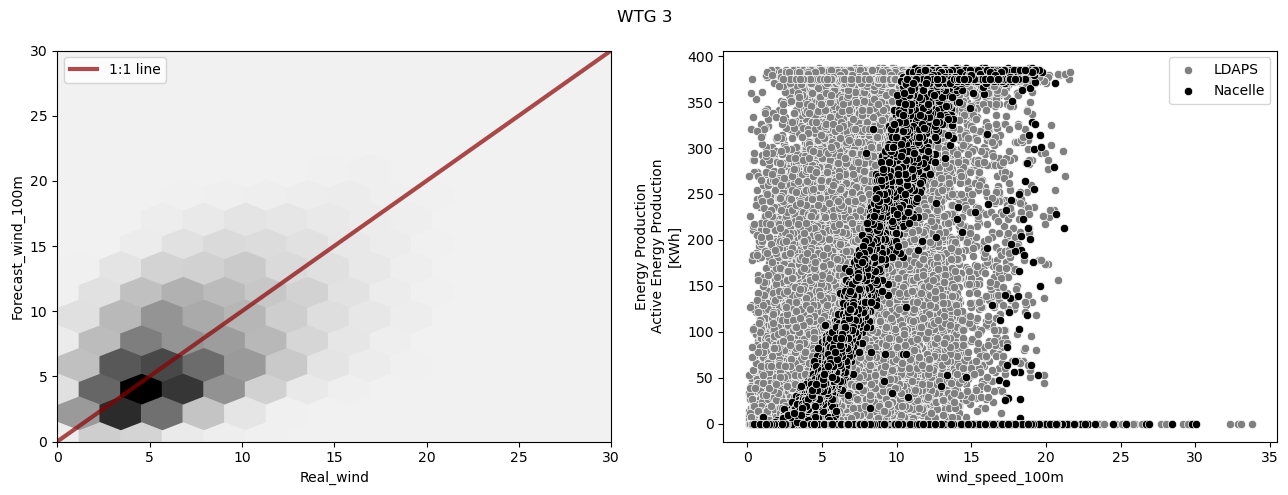

c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


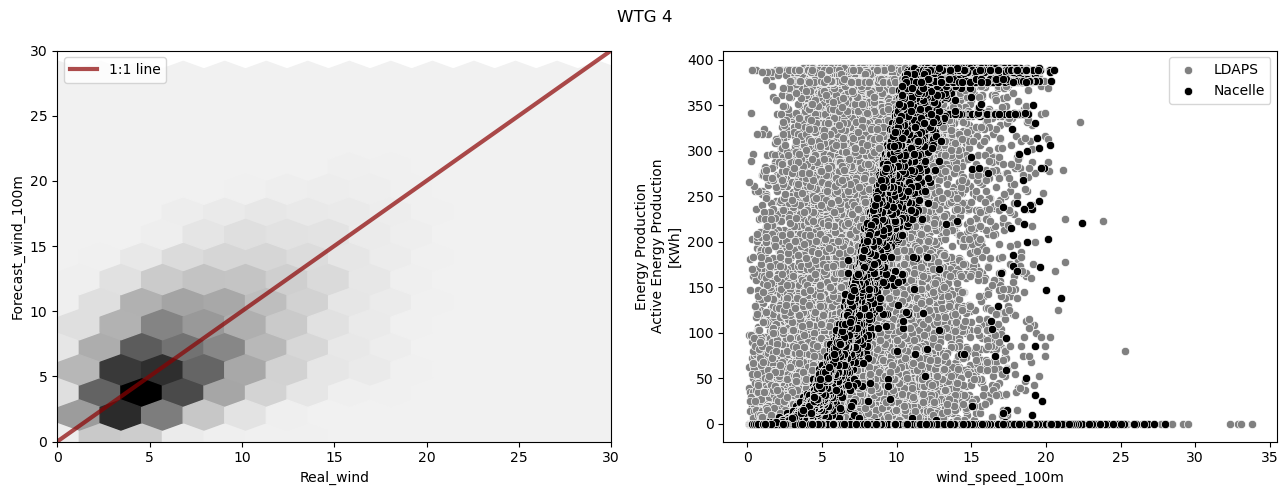

c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


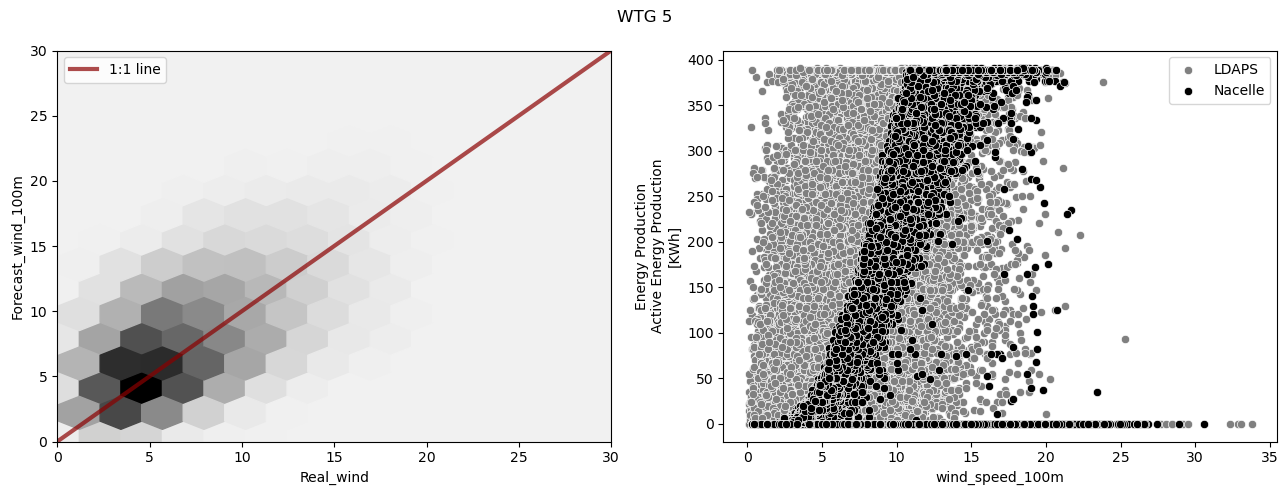

c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


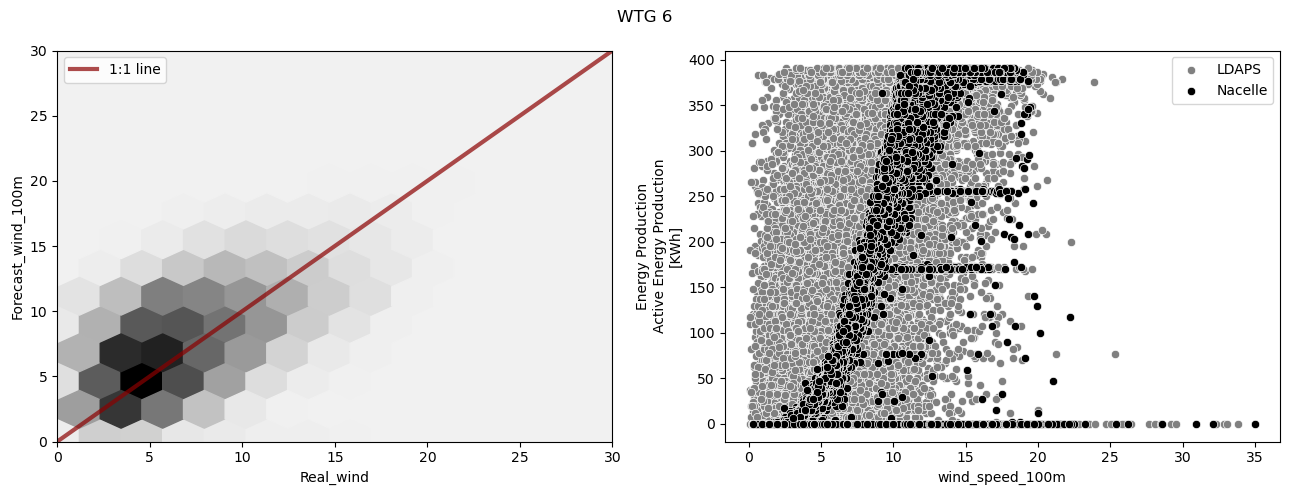

c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


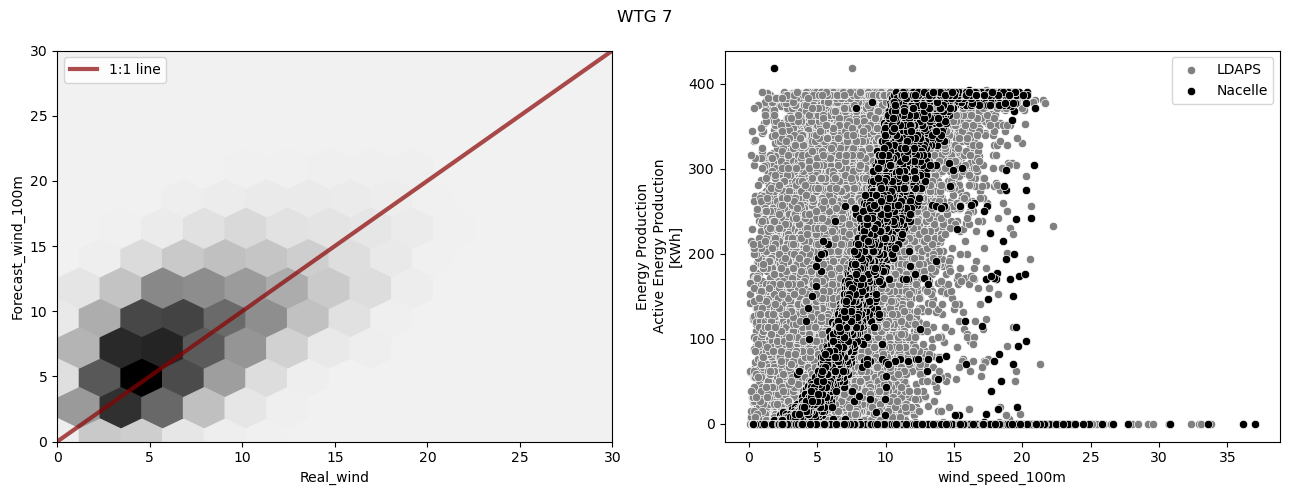

c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


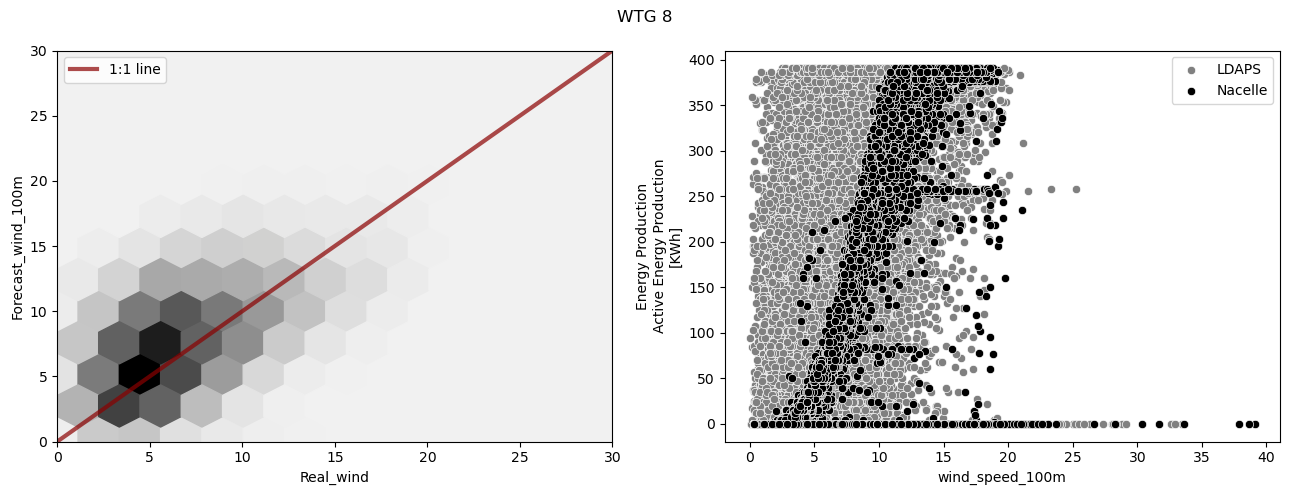

c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


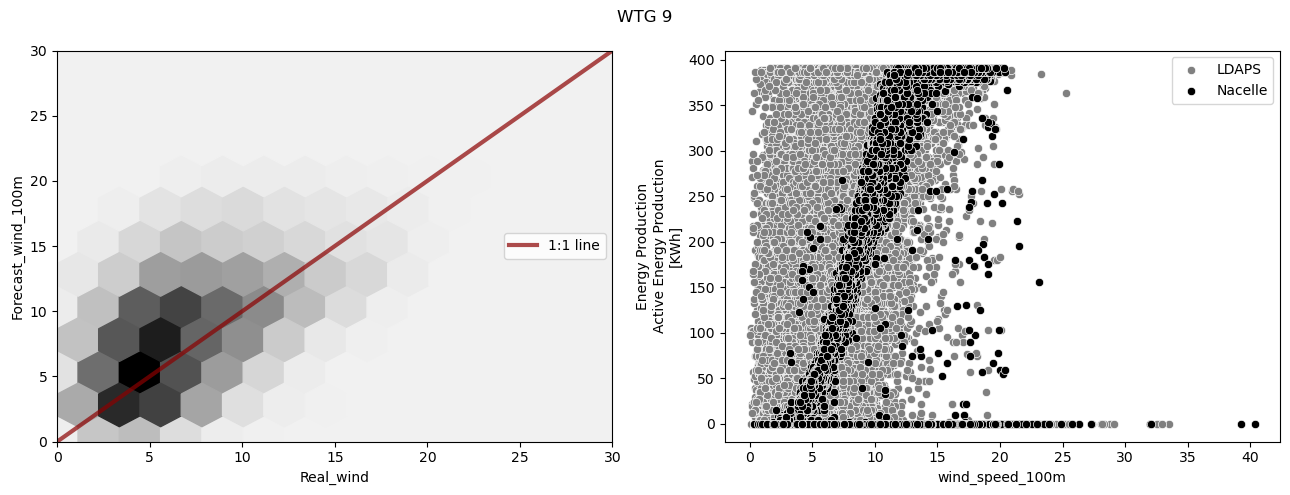

In [55]:
path = "C:/Users/jhk32/Downloads/공모전 제공용 데이터 및 예제/3-2. 분석용데이터_경주풍력_SCADA/"
ldaps = pd.read_parquet(INPUT_PATH + "train_ldaps_gyeongju.parquet")

def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)

for i in range(9):
    power1 = (pd.read_excel(path + "dynamic_report_ewp02_2020_10min.xlsx", index_col = None, sheet_name = i, header = 5)
            .rename(columns = {'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}));
    power2 = (pd.read_excel(path + "dynamic_report_ewp02_2021_10min.xlsx", index_col = None, sheet_name = i, header = 5)
            .rename(columns = {'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}));
    power3 = (pd.read_excel(path + "dynamic_report_ewp02_2022_10min.xlsx", index_col = None, sheet_name = i, header = 5)
            .rename(columns = {'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}));

    power = pd.concat([power1, power2, power3], axis=0)

    idx = power.loc[power['dt'].isin(['Summation', 'Average', 'Standard Deviation'])].index
    power.drop(idx, axis=0, inplace=True)

    try:
        power['dt'] = (pd.to_datetime(power['dt'])
                        .dt
                        .tz_convert("Asia/Seoul"))
    except TypeError:
        power['dt'] = (pd.to_datetime(power['dt'])
                        .dt
                        .tz_localize("Asia/Seoul"))

    tmp = pd.merge(ldaps[ldaps['turbine_id'].str.slice(3, 5).astype(int) == i+1], power, how='inner', on='dt')
    del power

    tmp['wind_speed'], tmp['wind_direction'] = uv_to_wsd(tmp['wind_u_10m'], tmp['wind_v_10m'])

    tmp['wind_speed_100m'] = logarithmic_profile(tmp['wind_speed'], 10, 100, tmp['surf_rough'])

    plt.figure(figsize=(13,5))
    plt.suptitle(f"WTG {i + 1}")

    plt.subplot(1, 2, 1)
    hexbin(tmp['wind_speed_100m'], tmp['Nacelle\nWind Speed\n[m/s]'], color='black')
    plt.plot([0,50], [0,50], color='darkred', alpha=0.7, linewidth=3, label='1:1 line')
    plt.xlabel('Real_wind')
    plt.ylabel('Forecast_wind_100m')



    plt.xlim([0,30])
    plt.ylim([0,30])
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.scatterplot(data=tmp,
                x='wind_speed_100m', y='Energy Production\nActive Energy Production\n[KWh]',
                color='gray', label='LDAPS')
    sns.scatterplot(data=tmp,
                x='Nacelle\nWind Speed\n[m/s]', y='Energy Production\nActive Energy Production\n[KWh]',
                color='black', label='Nacelle')
    plt.legend()

    plt.tight_layout()
    plt.show()

c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


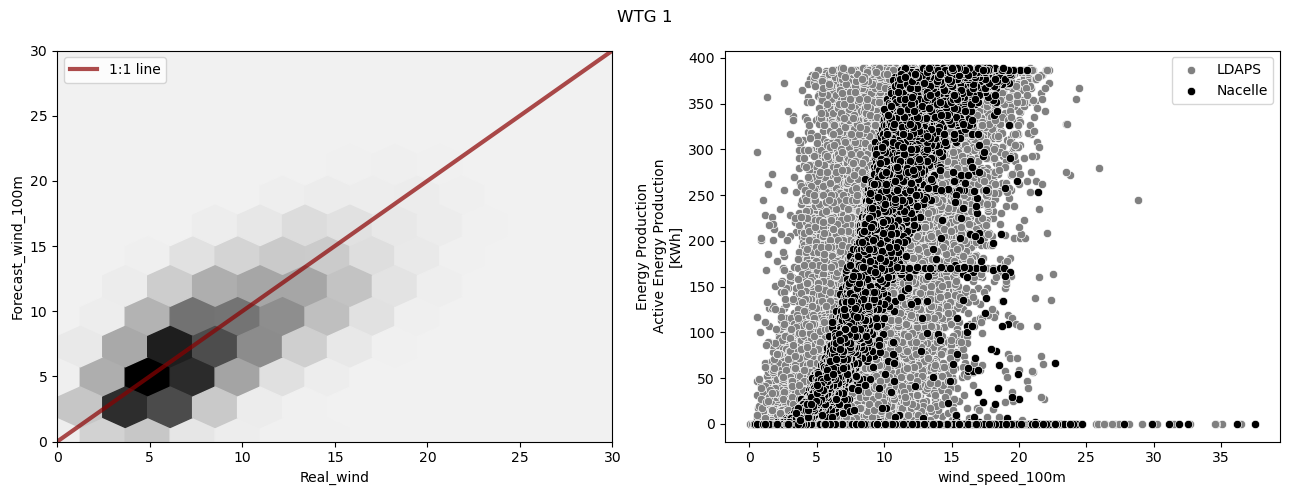

In [2]:
path = "C:/Users/jhk32/Downloads/공모전 제공용 데이터 및 예제/3-2. 분석용데이터_경주풍력_SCADA/"
ldaps = pd.read_parquet(INPUT_PATH + "train_ldaps_gyeongju.parquet")

def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)

i = 0
power1 = (pd.read_excel(path + "dynamic_report_ewp02_2020_10min.xlsx", index_col = None, sheet_name = i, header = 5)
        .rename(columns = {'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}));
power2 = (pd.read_excel(path + "dynamic_report_ewp02_2021_10min.xlsx", index_col = None, sheet_name = i, header = 5)
        .rename(columns = {'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}));
power3 = (pd.read_excel(path + "dynamic_report_ewp02_2022_10min.xlsx", index_col = None, sheet_name = i, header = 5)
        .rename(columns = {'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}));

power = pd.concat([power1, power2, power3], axis=0)

idx = power.loc[power['dt'].isin(['Summation', 'Average', 'Standard Deviation'])].index
power.drop(idx, axis=0, inplace=True)

try:
    power['dt'] = (pd.to_datetime(power['dt'])
                    .dt
                    .tz_convert("Asia/Seoul"))
except TypeError:
    power['dt'] = (pd.to_datetime(power['dt'])
                    .dt
                    .tz_localize("Asia/Seoul"))

tmp = pd.merge(ldaps[ldaps['turbine_id'].str.slice(3, 5).astype(int) == i+1], power, how='inner', on='dt')
del power

tmp['wind_speed'], tmp['wind_direction'] = uv_to_wsd(tmp['wind_u_10m'], tmp['wind_v_10m'])

tmp['wind_speed_100m'] = logarithmic_profile(tmp['wind_speed'], 10, 100, tmp['surf_rough'])

plt.figure(figsize=(13,5))
plt.suptitle(f"WTG {i + 1}")

plt.subplot(1, 2, 1)
hexbin(tmp['wind_speed_100m'], tmp['Nacelle\nWind Speed\n[m/s]'], color='black')
plt.plot([0,50], [0,50], color='darkred', alpha=0.7, linewidth=3, label='1:1 line')
plt.xlabel('Real_wind')
plt.ylabel('Forecast_wind_100m')



plt.xlim([0,30])
plt.ylim([0,30])
plt.legend()

plt.subplot(1, 2, 2)
sns.scatterplot(data=tmp,
            x='wind_speed_100m', y='Energy Production\nActive Energy Production\n[KWh]',
            color='gray', label='LDAPS')
sns.scatterplot(data=tmp,
            x='Nacelle\nWind Speed\n[m/s]', y='Energy Production\nActive Energy Production\n[KWh]',
            color='black', label='Nacelle')
plt.legend()

plt.tight_layout()
plt.show()

In [3]:
import gc
gc.collect()

196669

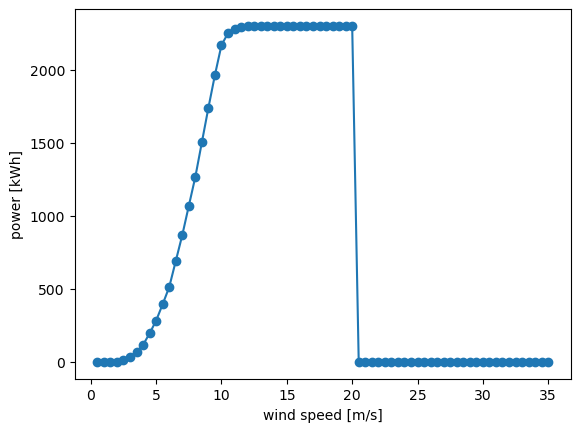

In [6]:
path = "C:/Users/jhk32/Downloads/공모전 제공용 데이터 및 예제/"
power_curve = pd.read_excel(path + "4-3. Power_curves_20210323.xls", sheet_name=2, skiprows=1)
pc_unison_u113 = power_curve.loc[power_curve.iloc[:,3] == "U113"].\
    iloc[0,5:75].to_dict()
# 파워커브는 발전량-풍속 간 관계식이며, dictionary의 key=풍속, value=출력
plt.plot(pc_unison_u113.keys(), pc_unison_u113.values(), marker='o')
plt.xlabel("wind speed [m/s]")
plt.ylabel("power [kWh]")
plt.show()

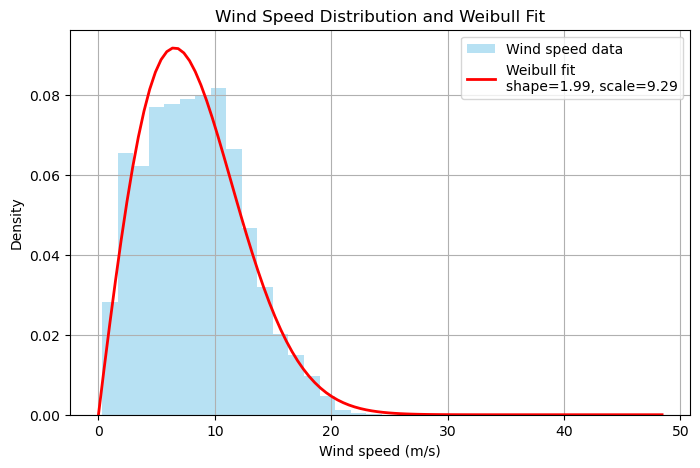

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

wind_speeds = tmp['Nacelle\nWind Speed\n[m/s]']

# 와이블 분포 파라미터 추정
shape_param, loc, scale_param = weibull_min.fit(wind_speeds, floc=0)

# x 값 생성 (풍속 범위)
x = np.linspace(0, max(wind_speeds) * 1.2, 100)

# 와이블 분포의 확률 밀도 함수 (PDF) 계산
pdf = weibull_min.pdf(x, shape_param, loc, scale_param)

# 그래프 그리기
plt.figure(figsize=(8, 5))
plt.hist(wind_speeds, bins=30, density=True, alpha=0.6, color='skyblue', label='Wind speed data')
plt.plot(x, pdf, 'r-', lw=2, label=f'Weibull fit\nshape={shape_param:.2f}, scale={scale_param:.2f}')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Density')
plt.title('Wind Speed Distribution and Weibull Fit')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
import numpy as np
from scipy.stats import weibull_min

# 관측값 및 예측값 (사용자의 실제 데이터를 여기에 넣으세요)
observed_values = tmp['Nacelle\nWind Speed\n[m/s]']
predicted_values = tmp['wind_speed_100m']

# 관측값으로부터 와이블 분포 파라미터 추정
shape_param, loc, scale_param = weibull_min.fit(observed_values, floc=0)

# 관측값의 CDF 계산
observed_cdf = weibull_min.cdf(observed_values, shape_param, loc, scale_param)

# 예측값의 CDF 계산
predicted_cdf = weibull_min.cdf(predicted_values, shape_param, loc, scale_param)

# 예측값을 보정하기 위해, 관측값의 분포를 사용하여 보정된 값을 계산
adjusted_values = weibull_min.ppf(predicted_cdf, shape_param, loc, scale_param)

print("Original Predicted Values:", predicted_values)
print("Adjusted Values:", adjusted_values)

Original Predicted Values: 0        12.879008
1        13.110820
2        13.156212
3        12.568782
4        11.824823
           ...    
25815    14.597685
25816    15.118364
25817    15.047703
25818    13.454048
25819    12.224750
Name: wind_speed_100m, Length: 25820, dtype: float32
Adjusted Values: [12.87900795 13.11081968 13.15621123 ... 15.04770244 13.45404785
 12.22474921]


In [44]:
tmp['adjust_wind_speed_100m'] = adjusted_values

In [45]:
def power_curve_fit(speed, density, coef):
    temp_speed = np.where(speed < 2.5, 0,
                          np.where(speed >= 20, 0, speed))
    ideal_energy = (temp_speed ** 3)*density*0.5*coef

    curve_fitted = np.where(ideal_energy >= 388.672, 388.672, ideal_energy) 
    return curve_fitted

tmp['ideal_energy_production'] = power_curve_fit(tmp['wind_speed_100m'], tmp['Nacelle\nAir Density\n[kg/㎥]'], 0.29)
tmp['adjust_ideal_energy_production'] = power_curve_fit(tmp['adjust_wind_speed_100m'], tmp['Nacelle\nAir Density\n[kg/㎥]'], 0.29)

In [39]:
# tmp['powercurve_fit_speed'] = np.where(tmp['wind_speed_100m'] < 2.5, 0,
#                                        np.where(tmp['wind_speed_100m'] >= 20, 0, tmp['wind_speed_100m']))

# tmp['ideal_energy_production'] = (tmp['powercurve_fit_speed'] ** 3)*tmp['Nacelle\nAir Density\n[kg/㎥]']*0.5*0.29

# # rated_ideal = (12 ** 3) *tmp['Nacelle\nAir Density\n[kg/㎥]']*0.5

# tmp['ideal_energy_production'] = np.where(tmp['ideal_energy_production'] >= 388.672, 388.672, tmp['ideal_energy_production']) 

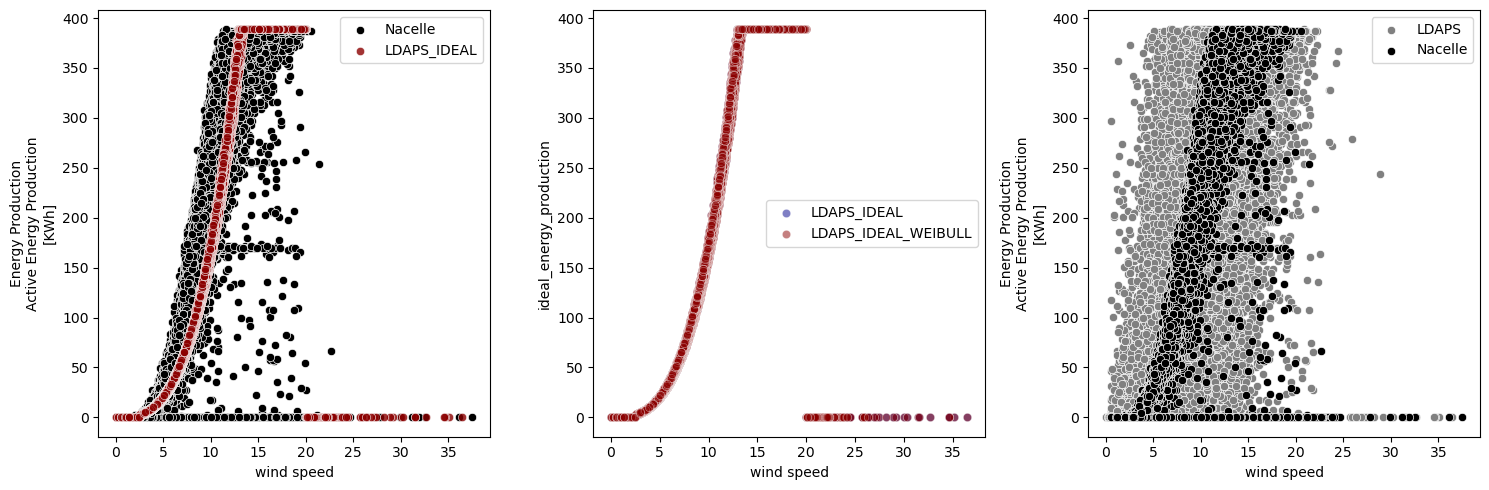

In [48]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(data=tmp,
                x='Nacelle\nWind Speed\n[m/s]', y='Energy Production\nActive Energy Production\n[KWh]',
                color='black', label='Nacelle')

sns.scatterplot(data=tmp, 
                x='wind_speed_100m', y='ideal_energy_production',
                color='darkred', label='LDAPS_IDEAL', alpha=0.8)
plt.xlabel('wind speed')

plt.subplot(1, 3, 2)
sns.scatterplot(data=tmp, 
                x='wind_speed_100m', y='ideal_energy_production',
                color='darkblue', label='LDAPS_IDEAL', alpha=0.5)

sns.scatterplot(data=tmp, 
                x='adjust_wind_speed_100m', y='adjust_ideal_energy_production',
                color='darkred', label='LDAPS_IDEAL_WEIBULL', alpha=0.5)
plt.xlabel('wind speed')

plt.subplot(1, 3, 3)
sns.scatterplot(data=tmp,
                x='wind_speed_100m', y='Energy Production\nActive Energy Production\n[KWh]',
                color='gray', label='LDAPS')
sns.scatterplot(data=tmp,
            x='Nacelle\nWind Speed\n[m/s]', y='Energy Production\nActive Energy Production\n[KWh]',
            color='black', label='Nacelle')

plt.xlabel('wind speed')

plt.tight_layout()
plt.show()

In [55]:
np.abs((tmp['Energy Production\nActive Energy Production\n[KWh]'] - tmp['adjust_ideal_energy_production'])).sum()

2127555.0115356743

<Axes: xlabel='Energy Production\nActive Energy Production\n[KWh]', ylabel='Density'>

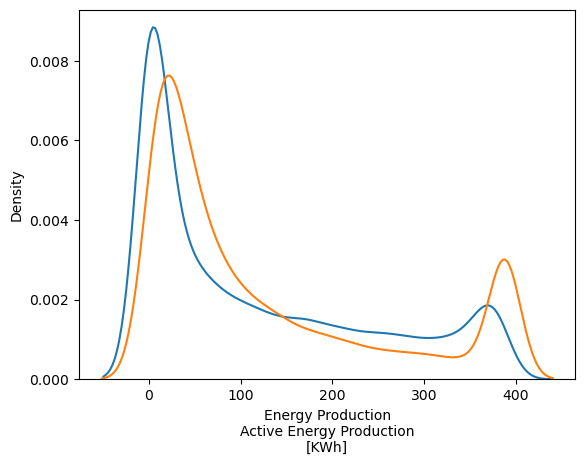

In [59]:
sns.kdeplot(tmp['Energy Production\nActive Energy Production\n[KWh]'])
sns.kdeplot(tmp['adjust_ideal_energy_production'])

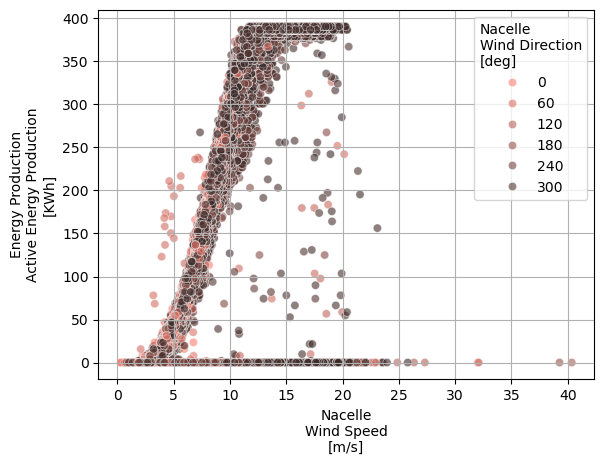

In [66]:
sns.scatterplot(data=tmp,
            x='Nacelle\nWind Speed\n[m/s]', y='Energy Production\nActive Energy Production\n[KWh]',
            hue='Nacelle\nWind Direction\n[deg]', alpha=0.6, palette='dark:salmon_r')
plt.grid()